In [61]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')

In [62]:
from importlib import reload

import pickle
import time

import numpy as np
import tensorflow as tf
import logging
from scipy import integrate
from scipy import interpolate
from scipy import linalg
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable

import plot_func as pf
import util_func as uf

import dev_ori_sel_RF
from dev_ori_sel_RF import data_dir,network,connectivity,dynamics_np,probe_RFs
from dev_ori_sel_RF.tools import misc,update_params_dict,gen_gaussian_random_field

# Create Gabor Filter RFs

In [63]:
N = 60
Nlgn = N

xs,ys = np.meshgrid(np.arange(N)/N-0.5,np.arange(N)/N-0.5)

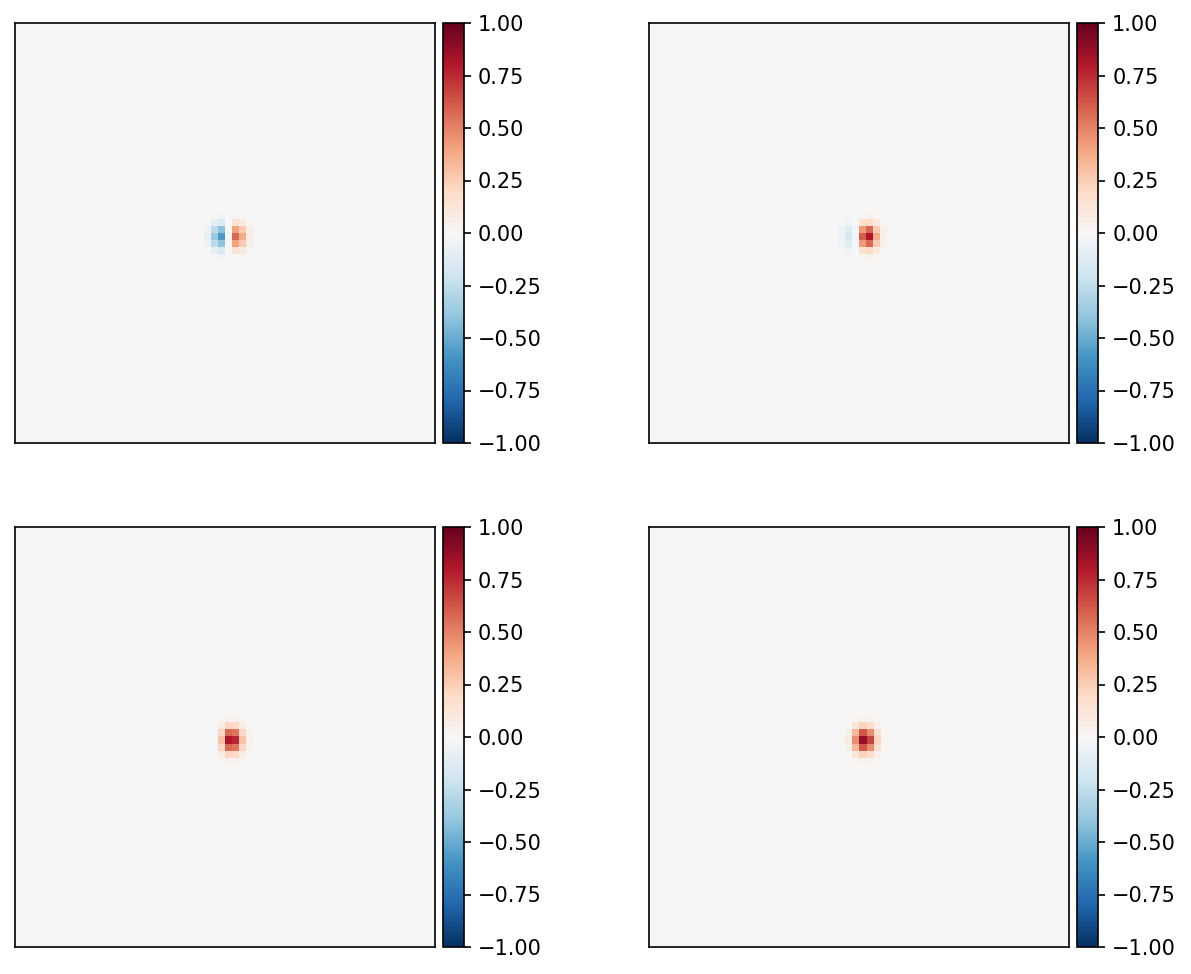

In [64]:
σ = 0.02
k = 0.5/σ

fig,axs = plt.subplots(2,2,figsize=(10,8),dpi=150)

def fun(phi):
    return np.exp(-0.5*(xs**2+ys**2)/σ**2)*np.sin(k*xs+phi)/np.sqrt(np.sin(phi)**2+(k*σ)**2)#np.sin(k*σ+phi)

pf.imshowbar(fig,axs[0,0],fun(0),vmin=-1,vmax=1)
pf.imshowbar(fig,axs[0,1],fun(np.pi/8),vmin=-1,vmax=1)
pf.imshowbar(fig,axs[1,0],fun(np.pi/4),vmin=-1,vmax=1)
pf.imshowbar(fig,axs[1,1],fun(np.pi*3/8),vmin=-1,vmax=1)

In [65]:
def squeezed_gabor_OS(sigbar,phi,thresh):
    r0 = integrate.quad(lambda θ: np.fmax(0,np.sqrt(np.sin(phi)**2+(sigbar*np.cos(θ))**2)/\
                                            np.sqrt(np.sin(phi)**2+sigbar**2)-thresh),0,np.pi)[0]
    r1 = integrate.quad(lambda θ: np.cos(2*θ)*np.fmax(0,np.sqrt(np.sin(phi)**2+(sigbar*np.cos(θ))**2)/\
                                            np.sqrt(np.sin(phi)**2+sigbar**2)-thresh),0,np.pi)[0]
    return r1/r0

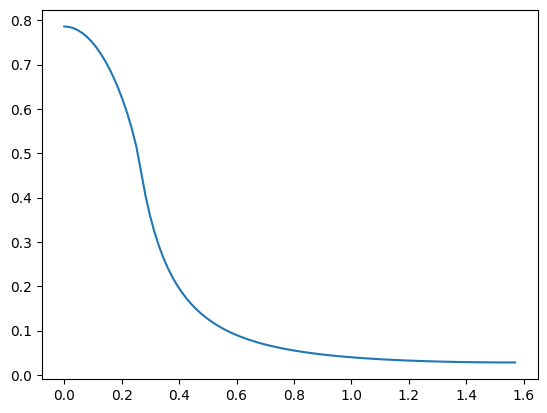

In [66]:
phis = np.linspace(0,np.pi/2,101)
RF_OSs = np.zeros_like(phis)

for phi_idx,phi in enumerate(phis):
    RF_OSs[phi_idx] = squeezed_gabor_OS(0.25,phi,0.72)
    
min_OS = np.min(RF_OSs)
max_OS = np.max(RF_OSs)

plt.plot(phis,RF_OSs)

In [67]:
RF_OS_itp = interpolate.interp1d(phis,RF_OSs,fill_value='extrapolate')
RF_OS_inv_itp = interpolate.interp1d(RF_OSs,phis,fill_value='extrapolate')

# Generate S&P Map, Create RFs Matching Map

In [68]:
ksel = 10**np.linspace(-3,0,7)[0]
lker = np.concatenate(([0],10**np.linspace(-3,0,7)[:-1]))[3]
grec = np.round(1.02*np.linspace(0.95,1.05,5),4)[2]
maxos = np.array([0.3,0.4,0.5,1.0])[-1]

with open('./../results/L23_sel_ksel={:.3f}_lker={:.3f}_grec={:.3f}_maxos={:.1f}/seed=0.pkl'.format(
        ksel,lker,grec,maxos), 'rb') as handle:
    res_dict = pickle.load(handle)
    
sim_L23_input_z = res_dict['inp_z']
sim_L23_rate_z = res_dict['rate_z']

In [69]:
xs,ys = np.meshgrid(np.arange(N)/N,np.arange(N)/N)
dxs = np.abs(xs[:,:,None,None] - xs[None,None,:,:])
dxs[dxs > 0.5] = 1 - dxs[dxs > 0.5]
dys = np.abs(ys[:,:,None,None] - ys[None,None,:,:])
dys[dys > 0.5] = 1 - dys[dys > 0.5]
ds2 = dxs**2 + dys**2
ds = np.sqrt(ds2)

In [70]:
def clip_r0(OSs):
    out = np.ones_like(OSs)
    out[OSs > 0.5] = (OSs[OSs > 0.5]*np.sqrt(4-1/OSs[OSs > 0.5]**2)+np.arccos(-0.5/OSs[OSs > 0.5]))/np.pi
    return out
    
def clip_r1(OSs):
    out = OSs.copy()
    out[OSs > 0.5] = (0.25*np.sqrt(4-1/OSs[OSs > 0.5]**2)+OSs[OSs > 0.5]*np.arccos(-0.5/OSs[OSs > 0.5]))/np.pi
    return out

def clip_OS(OSs):
    out = OSs.copy()
    out[OSs > 0.5] = (0.25*np.sqrt(4-1/OSs[OSs > 0.5]**2)+OSs[OSs > 0.5]*np.arccos(-0.5/OSs[OSs > 0.5]))/\
        (OSs[OSs > 0.5]*np.sqrt(4-1/OSs[OSs > 0.5]**2)+np.arccos(-0.5/OSs[OSs > 0.5]))
    return out

OSs = np.linspace(0.0,10000.0,20001)

thy_clip_OSs = clip_OS(OSs)
thy_clip_r0s = clip_r0(OSs)
thy_clip_r1s = clip_r1(OSs)

clip_r0_itp = interpolate.interp1d(OSs,thy_clip_r0s,fill_value='extrapolate')
inv_r1_itp = interpolate.interp1d(thy_clip_r1s,OSs,fill_value='extrapolate')
inv_OS_itp = interpolate.interp1d(thy_clip_OSs,OSs,fill_value='extrapolate')

def gen_clip_act(ori,z):
    etas = inv_OS_itp(np.abs(z))
    return np.fmax(0,1 + 2*etas*np.real(np.exp(-1j*ori*2*np.pi/180) * z/np.abs(z))) / clip_r0_itp(etas)

In [71]:
def gen_sp_opm(r1,shape,seed=0,tol=1e-2):
    rng = np.random.default_rng(seed)
    
    z = np.exp(1j*2*np.pi*rng.random(size=(N,N)))
    
    x = rng.gamma(shape=shape,scale=r1/shape,size=(N,N)) + 0.001*rng.random((N,N))
    x = clip_OS(x)
    x = np.fmax(1e-12,x)
    
    z *= x
    
    return z

In [72]:
avg_OS = 0.17

orig_z = gen_sp_opm(avg_OS,ksel)
# orig_z *= inv_OS_itp(np.abs(orig_z)**4) / np.fmax(1e-12,np.abs(orig_z))

lker2 = (lker)**2

if lker != 0.0:
    gauss = np.exp(-0.5*ds2/lker2)
else:
    gauss = (ds2 == 0.0).astype(float)
    
gauss /= np.sum(gauss,(-2,-1))[:,:,None,None]
    
L4_z = np.einsum('ijkl,kl->ij',gauss,orig_z * inv_OS_itp(np.abs(orig_z)) / np.fmax(1e-12,np.abs(orig_z)))

# fact = 1

while np.abs(np.mean(clip_OS(np.abs(L4_z))) - avg_OS) > 1e-3:
#     fact *= 1 - (np.mean(clip_OS(np.abs(L4_z))) - avg_OS)
#     L4_z *= np.einsum('ijkl,kl->ij',gauss,fact*orig_z * inv_OS_itp(np.abs(fact*orig_z)) /\
#                       np.fmax(1e-12,np.abs(fact*orig_z)))
    L4_z *= 1 - (np.mean(clip_OS(np.abs(L4_z))) - avg_OS)

L4_z *= clip_OS(np.abs(L4_z)) / np.fmax(1e-12,np.abs(L4_z))
    
# L4_z = np.einsum('ijkl,kl->ij',gauss,L4_z)

Mean S&P OS = 0.005921296939456462
Mean Smoothed OS = 0.16907378588133246


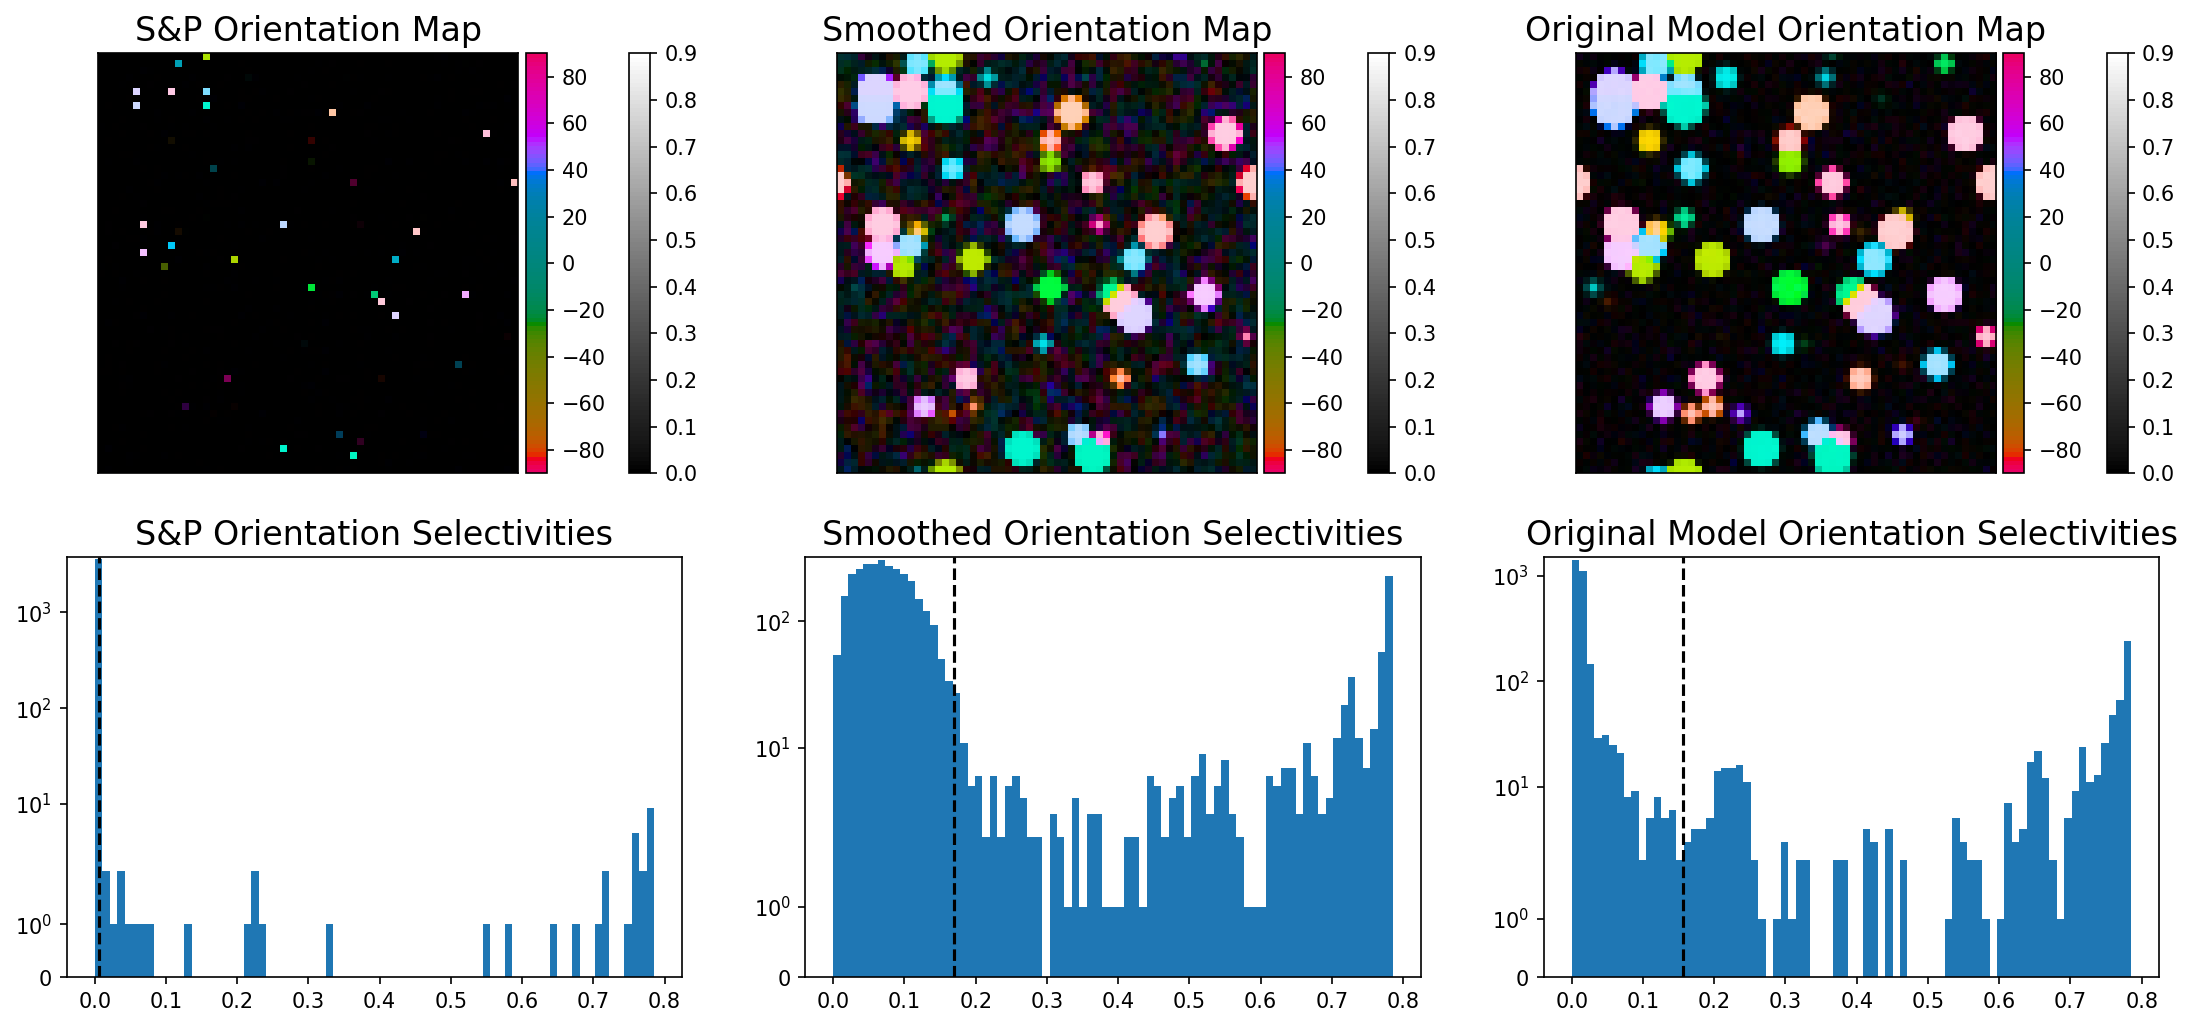

In [73]:
fig,axs = plt.subplots(2,3,figsize=(18,8),dpi=150)

pf.domcolbar(fig,axs[0,0],orig_z,origin='lower',alim=[-90,90],rlim=[0,0.9])
pf.domcolbar(fig,axs[0,1],L4_z,origin='lower',alim=[-90,90],rlim=[0,0.9])
pf.domcolbar(fig,axs[0,2],sim_L23_input_z,origin='lower',alim=[-90,90],rlim=[0,0.9])
axs[1,0].hist(np.abs(orig_z).flatten(),np.linspace(0,np.pi/4,76))
axs[1,0].axvline(np.mean(np.abs(orig_z)),c='k',ls='--')
axs[1,1].hist(np.abs(L4_z).flatten(),np.linspace(0,np.pi/4,76))
axs[1,1].axvline(np.mean(np.abs(L4_z)),c='k',ls='--')
axs[1,2].hist(np.abs(sim_L23_input_z).flatten(),np.linspace(0,np.pi/4,76))
axs[1,2].axvline(np.mean(np.abs(sim_L23_input_z)),c='k',ls='--')

axs[1,0].set_yscale('symlog')
axs[1,1].set_yscale('symlog')
axs[1,2].set_yscale('symlog')

axs[0,0].set_title('S&P Orientation Map',fontsize=16)
axs[0,1].set_title('Smoothed Orientation Map',fontsize=16)
axs[0,2].set_title('Original Model Orientation Map',fontsize=16)
axs[1,0].set_title('S&P Orientation Selectivities',fontsize=16)
axs[1,1].set_title('Smoothed Orientation Selectivities',fontsize=16)
axs[1,2].set_title('Original Model Orientation Selectivities',fontsize=16)

print('Mean S&P OS =',np.mean(np.abs(orig_z)))
print('Mean Smoothed OS =',np.mean(np.abs(L4_z)))

# Look at L4 Activity Map Needed to Generate L2/3 Inputs with Gaussian Weights

In [74]:
Wlker = lker*2
Wlker2 = Wlker**2

if Wlker != 0.0:
    W = np.exp(-0.5*ds2/Wlker2)
else:
    W = (ds2 == 0.0).astype(float)
    
W /= np.sum(W,(-2,-1))[:,:,None,None]

In [75]:
WinvL23 = (np.linalg.inv(W.reshape((N**2,N**2)))@L4_z.reshape((N**2))).reshape((N,N))

WinvL23 *= 0.15/np.mean(np.abs(WinvL23))

Mean S&P OS = 0.005921296939456462
Mean Smoothed OS = 0.15


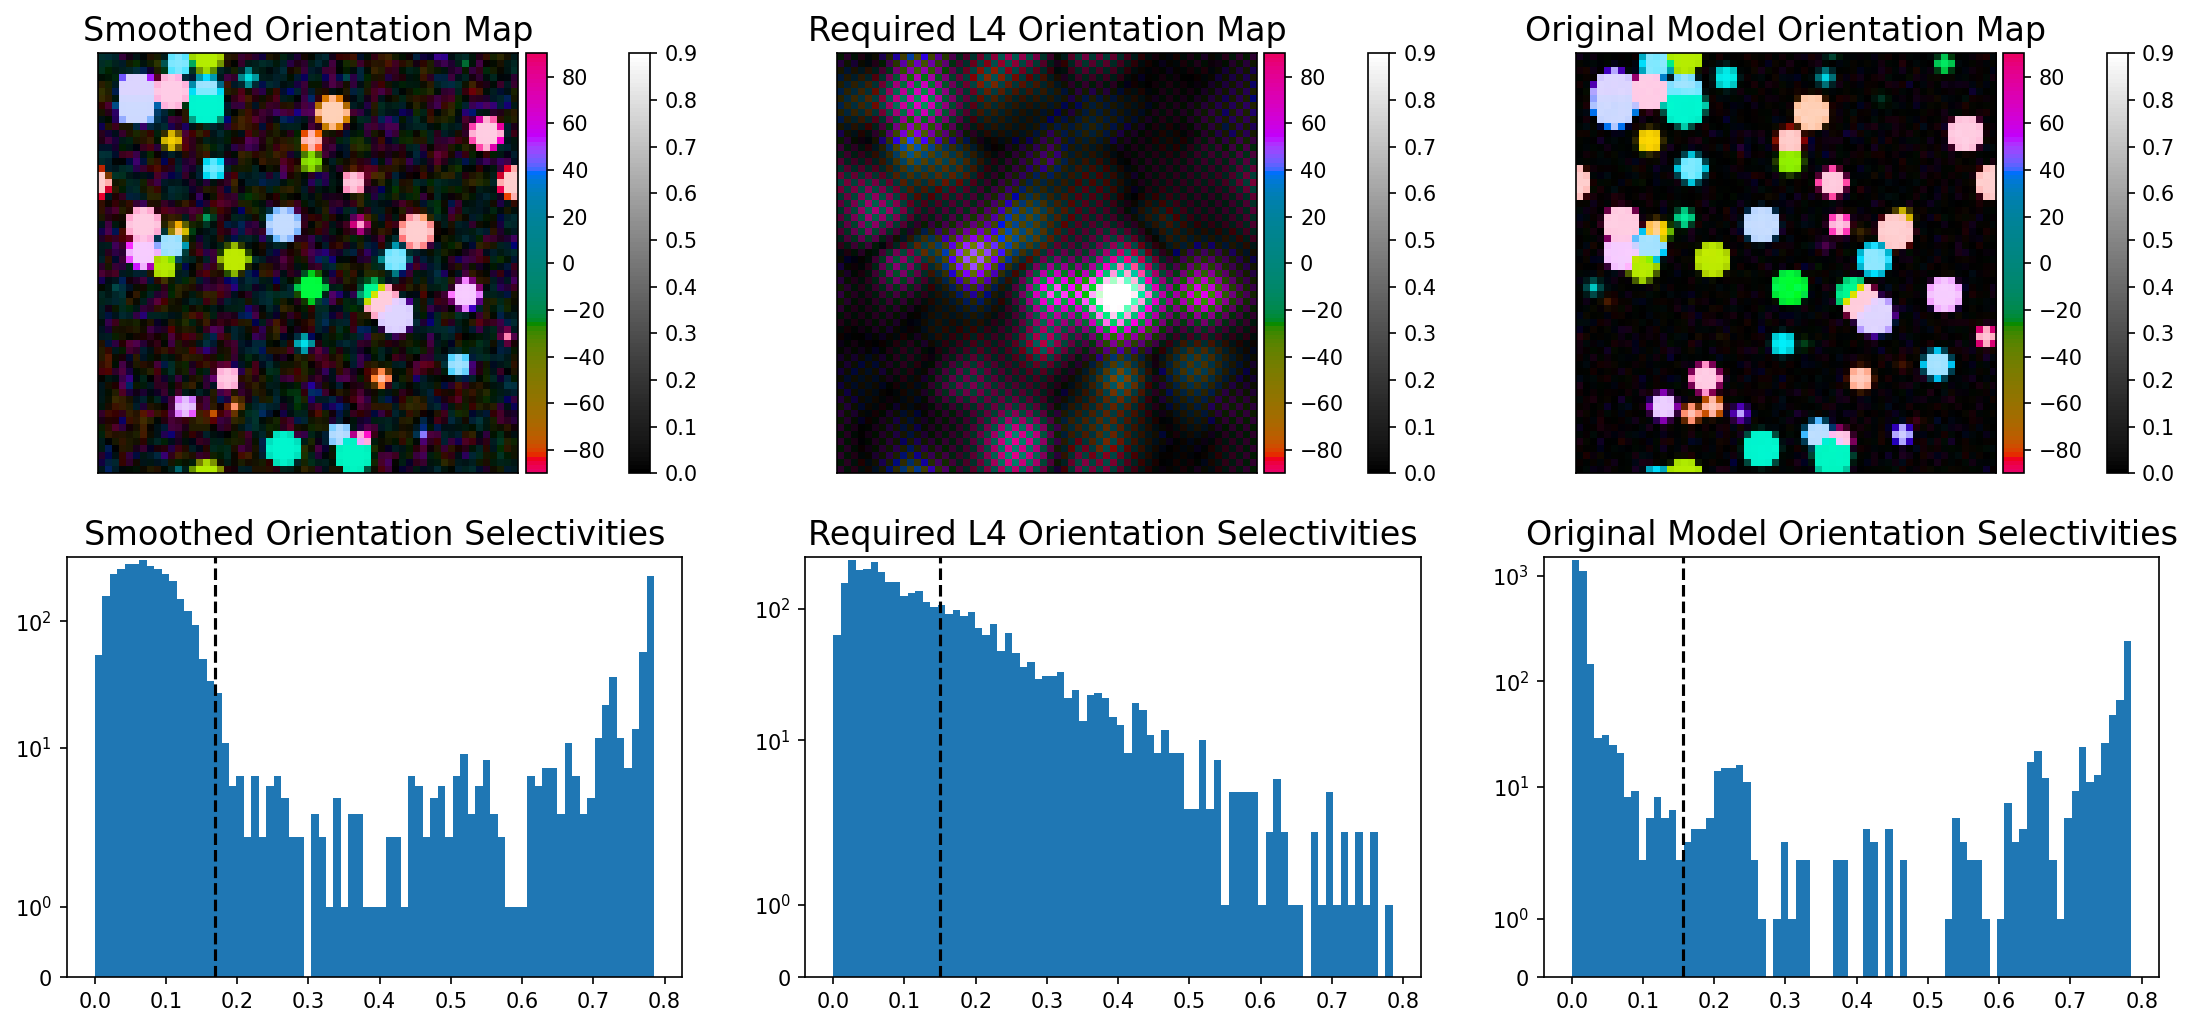

In [76]:
fig,axs = plt.subplots(2,3,figsize=(18,8),dpi=150)

pf.domcolbar(fig,axs[0,0],L4_z,origin='lower',alim=[-90,90],rlim=[0,0.9])
pf.domcolbar(fig,axs[0,1],WinvL23,origin='lower',alim=[-90,90],rlim=[0,0.9])
pf.domcolbar(fig,axs[0,2],sim_L23_input_z,origin='lower',alim=[-90,90],rlim=[0,0.9])
axs[1,0].hist(np.abs(L4_z).flatten(),np.linspace(0,np.pi/4,76))
axs[1,0].axvline(np.mean(np.abs(L4_z)),c='k',ls='--')
axs[1,1].hist(np.abs(WinvL23).flatten(),np.linspace(0,np.pi/4,76))
axs[1,1].axvline(np.mean(np.abs(WinvL23)),c='k',ls='--')
axs[1,2].hist(np.abs(sim_L23_input_z).flatten(),np.linspace(0,np.pi/4,76))
axs[1,2].axvline(np.mean(np.abs(sim_L23_input_z)),c='k',ls='--')

axs[1,0].set_yscale('symlog')
axs[1,1].set_yscale('symlog')
axs[1,2].set_yscale('symlog')

axs[0,0].set_title('Smoothed Orientation Map',fontsize=16)
axs[0,1].set_title('Required L4 Orientation Map',fontsize=16)
axs[0,2].set_title('Original Model Orientation Map',fontsize=16)
axs[1,0].set_title('Smoothed Orientation Selectivities',fontsize=16)
axs[1,1].set_title('Required L4 Orientation Selectivities',fontsize=16)
axs[1,2].set_title('Original Model Orientation Selectivities',fontsize=16)

print('Mean S&P OS =',np.mean(np.abs(orig_z)))
print('Mean Smoothed OS =',np.mean(np.abs(WinvL23)))

# Try Random Noisy Gaussian Weights

In [77]:
Wlker = 0.5*lker*2
Wlker2 = Wlker**2

if Wlker != 0.0:
    W = np.exp(-0.5*ds2/Wlker2)
else:
    W = (ds2 == 0.0).astype(float)
    
W *= np.random.default_rng(0).random((N,N))
# W *= np.random.default_rng(0).gamma(shape=0.1,scale=1,size=(N,N))
    
W /= np.sum(W,(-2,-1))[:,:,None,None]

In [78]:
WL4_z = np.einsum('ijkl,kl->ij',W,L4_z)

Mean S&P OS = 0.16907378588133246
Mean Smoothed OS = 0.14152511779833155


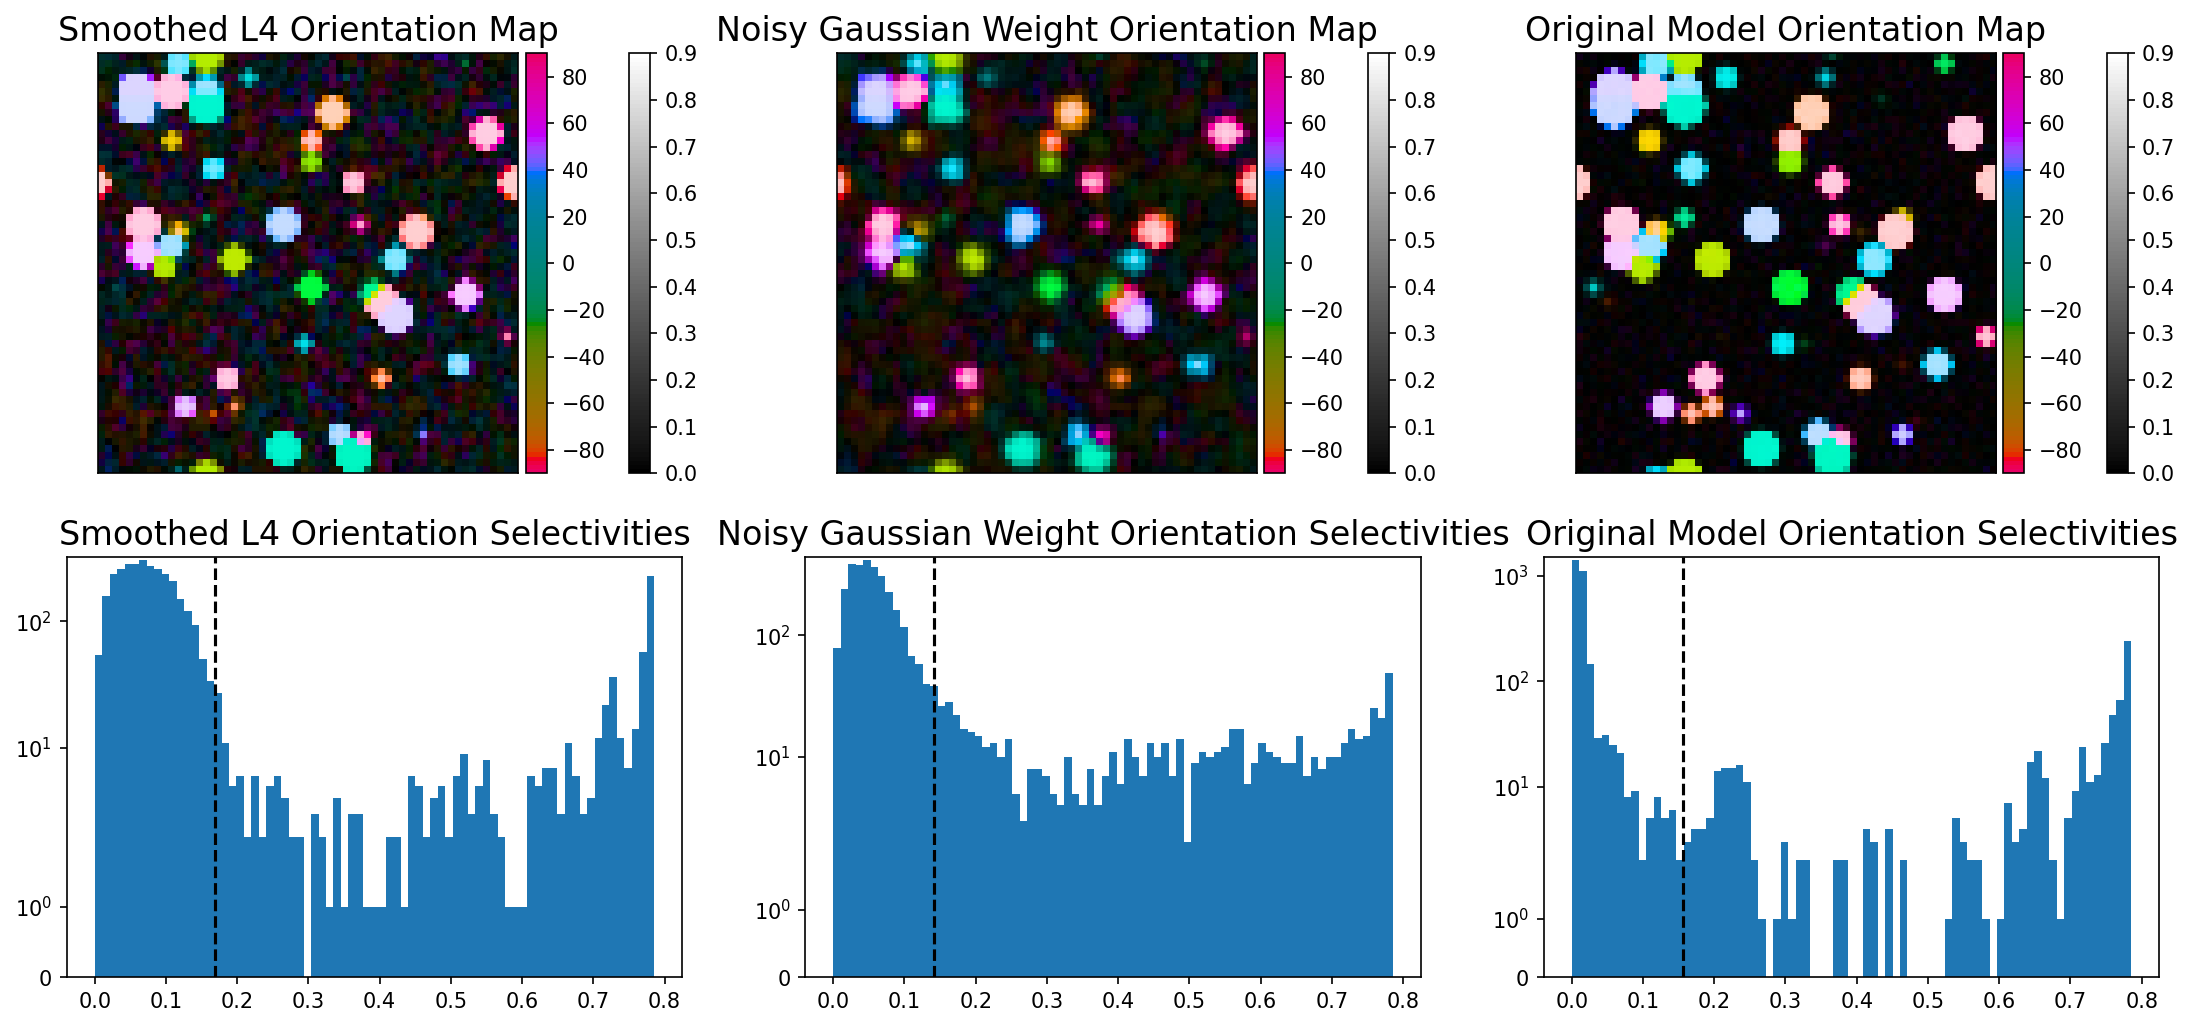

In [79]:
fig,axs = plt.subplots(2,3,figsize=(18,8),dpi=150)

pf.domcolbar(fig,axs[0,0],L4_z,origin='lower',alim=[-90,90],rlim=[0,0.9])
pf.domcolbar(fig,axs[0,1],WL4_z,origin='lower',alim=[-90,90],rlim=[0,0.9])
pf.domcolbar(fig,axs[0,2],sim_L23_input_z,origin='lower',alim=[-90,90],rlim=[0,0.9])
axs[1,0].hist(np.abs(L4_z).flatten(),np.linspace(0,np.pi/4,76))
axs[1,0].axvline(np.mean(np.abs(L4_z)),c='k',ls='--')
axs[1,1].hist(np.abs(WL4_z).flatten(),np.linspace(0,np.pi/4,76))
axs[1,1].axvline(np.mean(np.abs(WL4_z)),c='k',ls='--')
axs[1,2].hist(np.abs(sim_L23_input_z).flatten(),np.linspace(0,np.pi/4,76))
axs[1,2].axvline(np.mean(np.abs(sim_L23_input_z)),c='k',ls='--')

axs[1,0].set_yscale('symlog')
axs[1,1].set_yscale('symlog')
axs[1,2].set_yscale('symlog')

axs[0,0].set_title('Smoothed L4 Orientation Map',fontsize=16)
axs[0,1].set_title('Noisy Gaussian Weight Orientation Map',fontsize=16)
axs[0,2].set_title('Original Model Orientation Map',fontsize=16)
axs[1,0].set_title('Smoothed L4 Orientation Selectivities',fontsize=16)
axs[1,1].set_title('Noisy Gaussian Weight Orientation Selectivities',fontsize=16)
axs[1,2].set_title('Original Model Orientation Selectivities',fontsize=16)

print('Mean S&P OS =',np.mean(np.abs(L4_z)))
print('Mean Smoothed OS =',np.mean(np.abs(WL4_z)))

# Generate L2/3 Inputs from L4 Activity

## Add Noise to L2/3 Inputs

In [80]:
avg_CV = 0.4
n_bins = 10
oris = np.arange(60) * 180/60
L4_rates = np.zeros((len(oris),N,N))
L23_inputs = np.zeros((len(oris),N,N))

rng = np.random.default_rng(0)
for ori_idx,ori in enumerate(oris):
    L4_rates[ori_idx] = gen_clip_act(ori,L4_z)
    mean_inps = np.einsum('ijkl,kl->ij',W,L4_rates[ori_idx])
    
    inps = np.zeros((n_bins,N,N))
    shape = 1/avg_CV**2
    scale = mean_inps/shape
    for bin_idx in range(n_bins):
        inps[bin_idx] = rng.gamma(shape=shape,scale=scale)
        
    L23_inputs[ori_idx] = np.mean(inps,0)

In [81]:
L23_r0 = np.mean(L23_inputs,0)
L23_rs = np.mean(np.sin(oris*2*np.pi/180)[:,None,None]*L23_inputs,0)
L23_rc = np.mean(np.cos(oris*2*np.pi/180)[:,None,None]*L23_inputs,0)
L23_r1 = np.sqrt(L23_rs**2 + L23_rc**2)

L23_PO = np.arctan2(L23_rs,L23_rc)*180/(2*np.pi)
L23_PO[L23_PO > 90] -= 180
L23_OS = L23_r1/L23_r0

L23_z = L23_OS * np.exp(1j*L23_PO*2*np.pi/180)

Mean S&P OS = 0.16907378588133246
Mean Smoothed OS = 0.14315369118150148
Error in callback <function _draw_all_if_interactive at 0x13bf13c40> (for post_execute):


KeyboardInterrupt: 

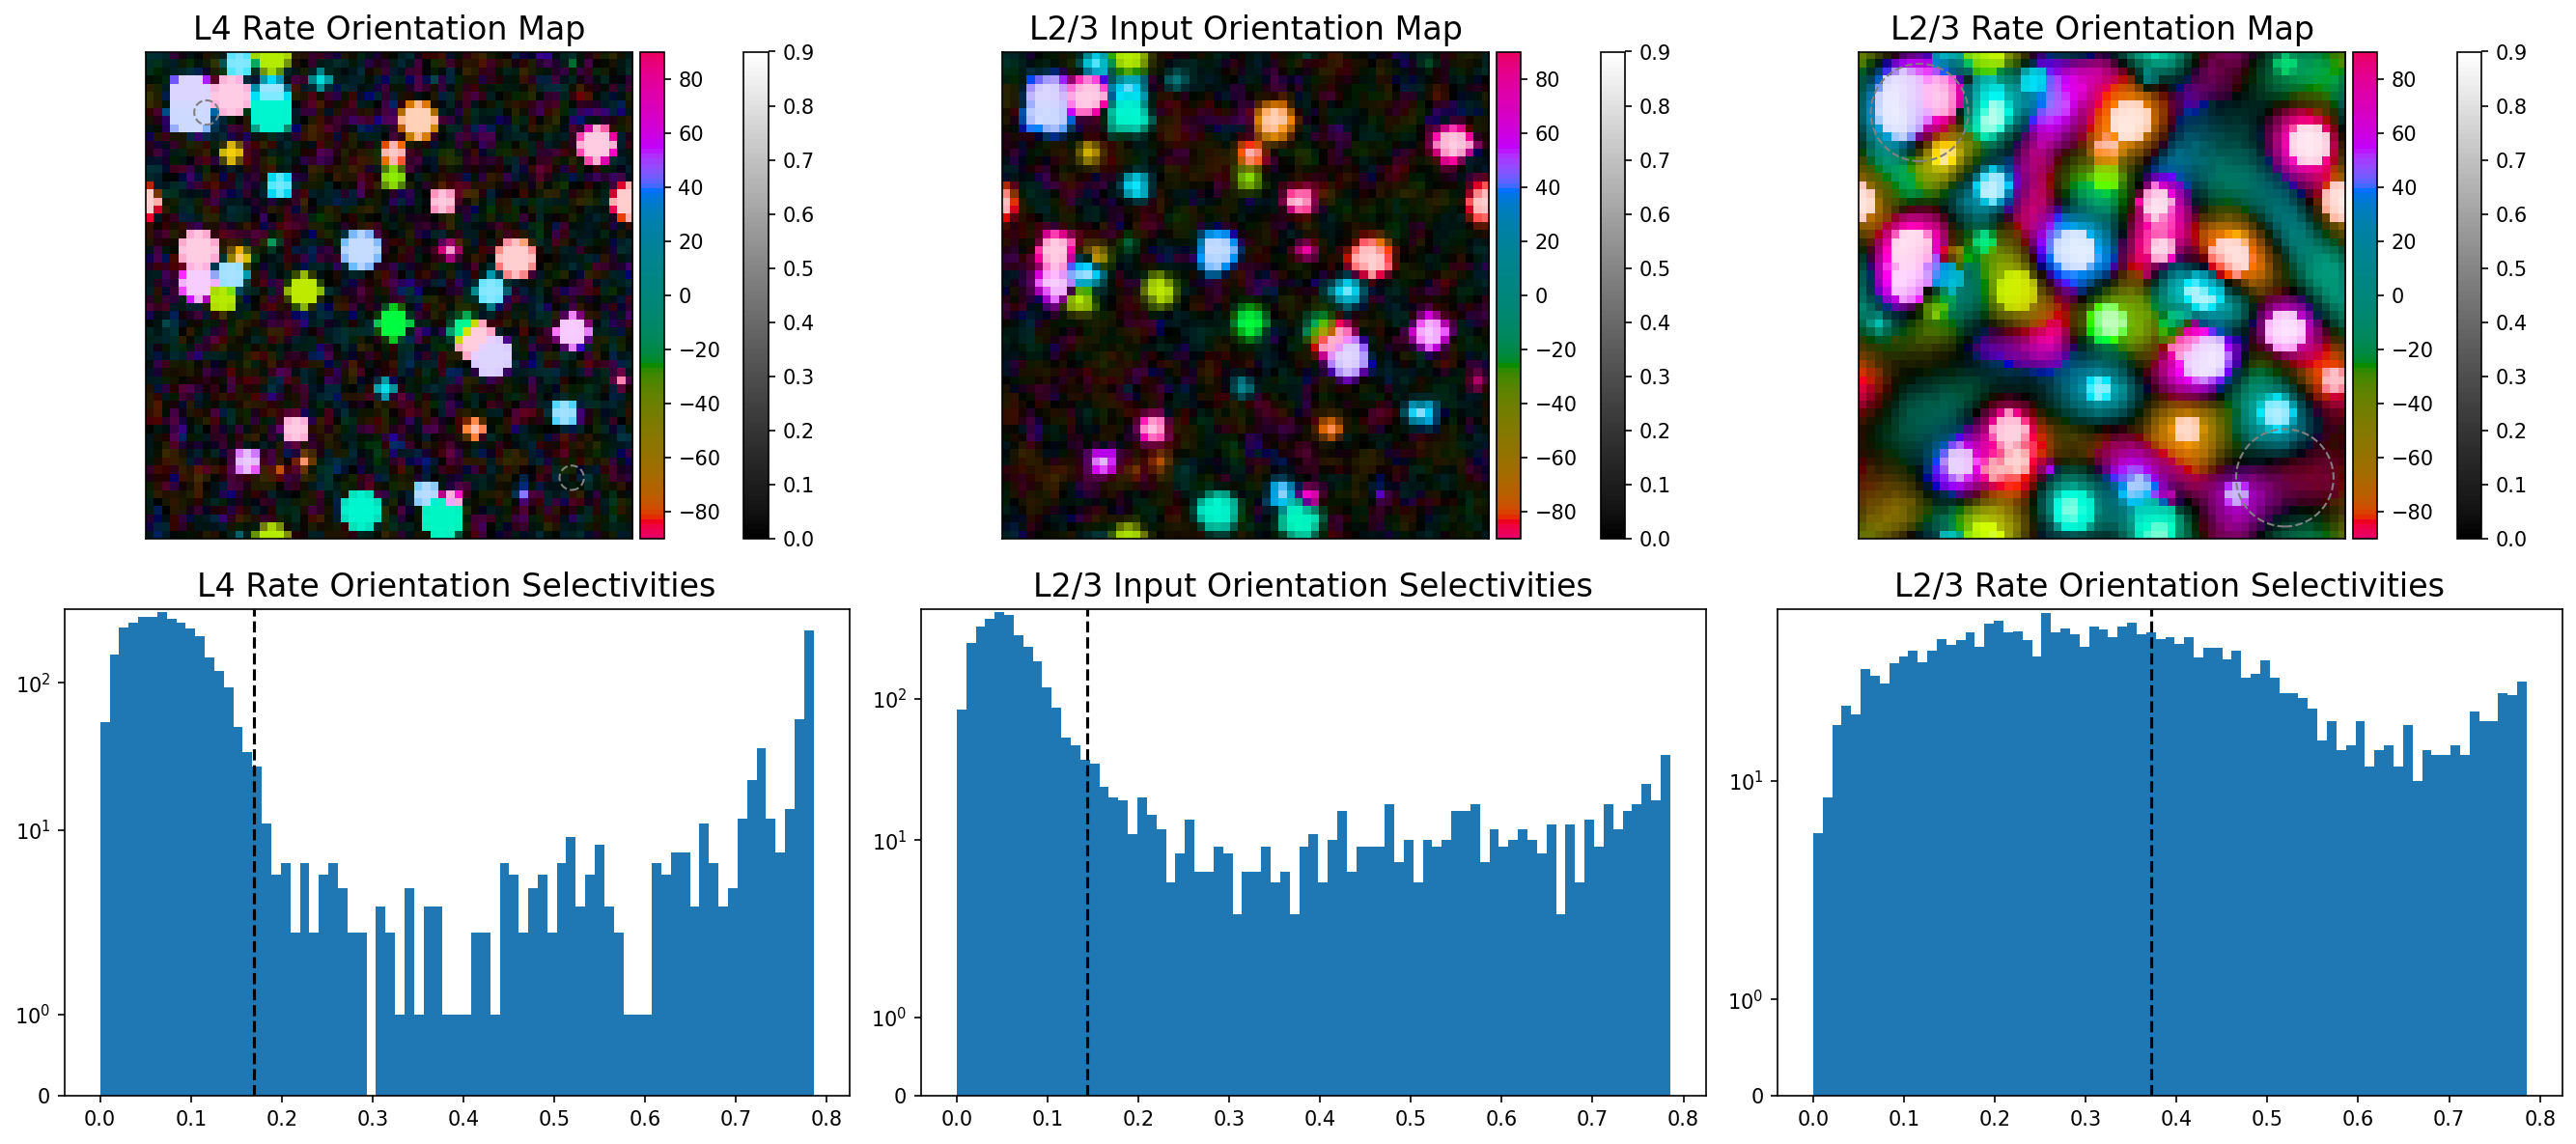

In [82]:
fig,axs = plt.subplots(2,3,figsize=(18,8),dpi=150)

pf.domcolbar(fig,axs[0,0],L4_z,origin='lower',alim=[-90,90],rlim=[0,0.9])
pf.domcolbar(fig,axs[0,1],L23_z,origin='lower',alim=[-90,90],rlim=[0,0.9])
# pf.domcolbar(fig,axs[0,2],sim_L23_input_z,origin='lower',alim=[-90,90],rlim=[0,0.9])
pf.domcolbar(fig,axs[0,2],sim_L23_rate_z[0],origin='lower',alim=[-90,90],rlim=[0,0.9])
axs[1,0].hist(np.abs(L4_z).flatten(),np.linspace(0,np.pi/4,76))
axs[1,0].axvline(np.mean(np.abs(L4_z)),c='k',ls='--')
axs[1,1].hist(np.abs(L23_z).flatten(),np.linspace(0,np.pi/4,76))
axs[1,1].axvline(np.mean(np.abs(L23_z)),c='k',ls='--')
# axs[1,2].hist(np.abs(sim_L23_input_z).flatten(),np.linspace(0,np.pi/4,76))
# axs[1,2].axvline(np.mean(np.abs(sim_L23_input_z)),c='k',ls='--')
axs[1,2].hist(np.abs(sim_L23_rate_z[0]).flatten(),np.linspace(0,np.pi/4,76))
axs[1,2].axvline(np.mean(np.abs(sim_L23_rate_z[0])),c='k',ls='--')

axs[1,0].set_yscale('symlog')
axs[1,1].set_yscale('symlog')
axs[1,2].set_yscale('symlog')

axs[0,0].set_title('L4 Rate Orientation Map',fontsize=16)
axs[0,1].set_title('L2/3 Input Orientation Map',fontsize=16)
axs[0,2].set_title('L2/3 Rate Orientation Map',fontsize=16)
axs[1,0].set_title('L4 Rate Orientation Selectivities',fontsize=16)
axs[1,1].set_title('L2/3 Input Orientation Selectivities',fontsize=16)
axs[1,2].set_title('L2/3 Rate Orientation Selectivities',fontsize=16)

nshow = 4

for i in range(N//nshow//2,N,N//nshow):
    for j in range(N//nshow//2,N,N//nshow):
        if np.abs(i - j) != range(N//nshow//2,N,N//nshow)[-1] - range(N//nshow//2,N,N//nshow)[0]:
            continue
        axs[0,0].add_patch(plt.Circle((i,j),2.5*Wlker*N, color='gray', ls='--', fill=False))
        axs[0,2].add_patch(plt.Circle((i,j),2.5*4*Wlker*N, color='gray', ls='--', fill=False))

print('Mean S&P OS =',np.mean(np.abs(L4_z)))
print('Mean Smoothed OS =',np.mean(np.abs(L23_z)))

fig.tight_layout()
fig.savefig('./../plots/L4 Model.pdf')

Text(0.5, 1.0, 'Original Model Orientation Selectivity')

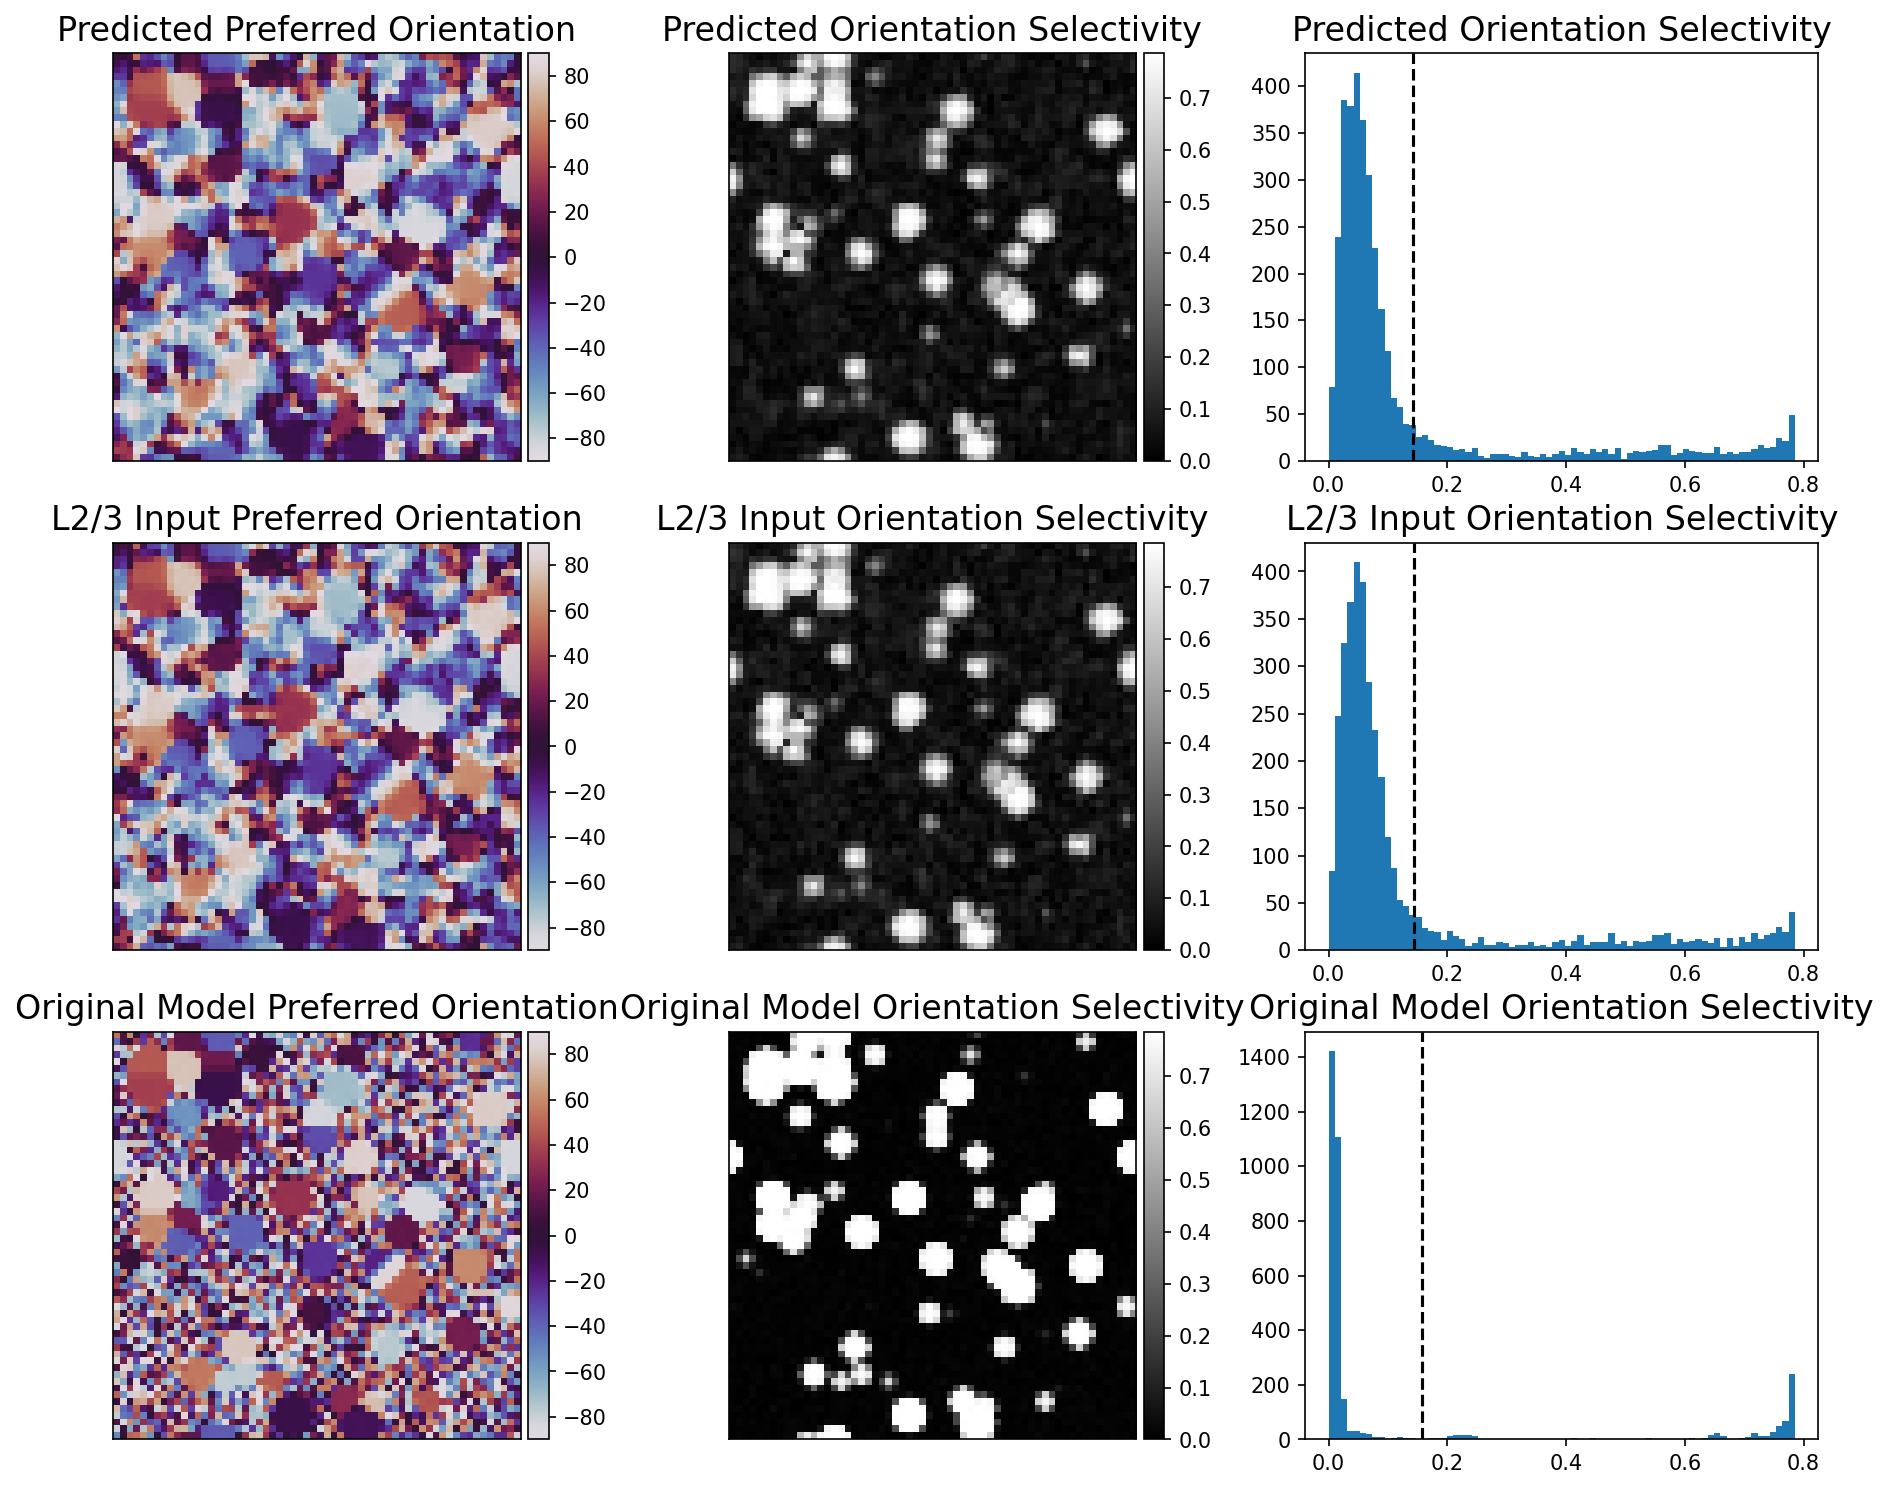

In [ ]:
fig,axs = plt.subplots(3,3,figsize=(15,12),dpi=150)

pf.imshowbar(fig,axs[0,0],np.angle(WL4_z)*180/(2*np.pi),origin='lower',cmap='twilight',vmin=-90,vmax=90)

pf.imshowbar(fig,axs[0,1],np.abs(WL4_z),origin='lower',cmap='binary_r',
             vmin=0,vmax=np.pi/4)

axs[0,2].hist(np.abs(WL4_z).flatten(),np.linspace(0,np.pi/4,76))
axs[0,2].axvline(np.mean(np.abs(WL4_z)),c='k',ls='--')

pf.imshowbar(fig,axs[1,0],np.angle(L23_z)*180/(2*np.pi),origin='lower',cmap='twilight',vmin=-90,vmax=90)

pf.imshowbar(fig,axs[1,1],np.abs(L23_z),origin='lower',cmap='binary_r',
             vmin=0,vmax=np.pi/4)

axs[1,2].hist(np.abs(L23_z).flatten(),np.linspace(0,np.pi/4,76))
axs[1,2].axvline(np.mean(np.abs(L23_z)),c='k',ls='--')

pf.imshowbar(fig,axs[2,0],np.angle(sim_L23_input_z)*180/(2*np.pi),origin='lower',cmap='twilight',vmin=-90,vmax=90)

pf.imshowbar(fig,axs[2,1],np.abs(sim_L23_input_z),origin='lower',cmap='binary_r',
             vmin=0,vmax=np.pi/4)

axs[2,2].hist(np.abs(sim_L23_input_z).flatten(),np.linspace(0,np.pi/4,76))
axs[2,2].axvline(np.mean(np.abs(sim_L23_input_z)),c='k',ls='--')

axs[0,0].set_title('Predicted Preferred Orientation',fontsize=16)
axs[0,1].set_title('Predicted Orientation Selectivity',fontsize=16)
axs[0,2].set_title('Predicted Orientation Selectivity',fontsize=16)
axs[1,0].set_title('L2/3 Input Preferred Orientation',fontsize=16)
axs[1,1].set_title('L2/3 Input Orientation Selectivity',fontsize=16)
axs[1,2].set_title('L2/3 Input Orientation Selectivity',fontsize=16)
axs[2,0].set_title('Original Model Preferred Orientation',fontsize=16)
axs[2,1].set_title('Original Model Orientation Selectivity',fontsize=16)
axs[2,2].set_title('Original Model Orientation Selectivity',fontsize=16)

In [ ]:
opm_mismatch = np.abs(L23_PO - np.angle(sim_L23_rate_z[0]) * 180/(2*np.pi))
opm_mismatch[opm_mismatch > 90] = 180 - opm_mismatch[opm_mismatch > 90]

sim_opm_mismatch = np.abs(np.angle(sim_L23_input_z) - np.angle(sim_L23_rate_z[0])) * 180/(2*np.pi)
sim_opm_mismatch[sim_opm_mismatch > 90] = 180 - sim_opm_mismatch[sim_opm_mismatch > 90]

34.47684652960145
33.553553031216886


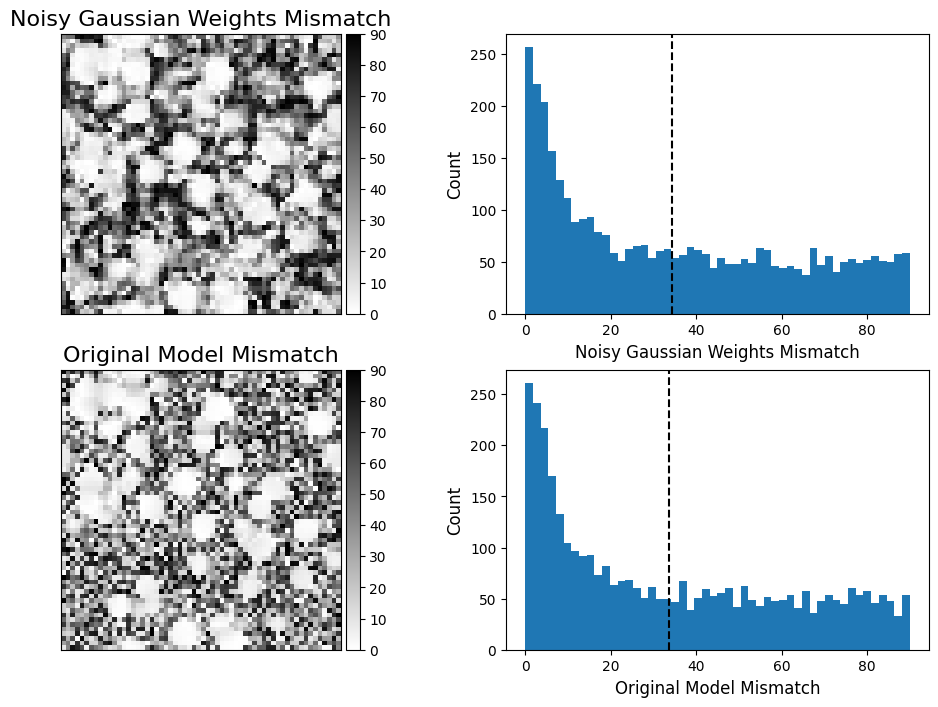

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(12,8))

pf.imshowbar(fig,axs[0,0],opm_mismatch,
             origin='lower',cmap='binary',vmin=0,vmax=90)
axs[0,1].hist(opm_mismatch.flatten(),50)
axs[0,1].axvline(np.mean(opm_mismatch),c='k',ls='--')

pf.imshowbar(fig,axs[1,0],sim_opm_mismatch,
             origin='lower',cmap='binary',vmin=0,vmax=90)
axs[1,1].hist(sim_opm_mismatch.flatten(),50)
axs[1,1].axvline(np.mean(sim_opm_mismatch),c='k',ls='--')

axs[0,0].set_title('Noisy Gaussian Weights Mismatch',fontsize=16)
axs[0,1].set_xlabel('Noisy Gaussian Weights Mismatch',fontsize=12)
axs[0,1].set_ylabel('Count',fontsize=12)
axs[1,0].set_title('Original Model Mismatch',fontsize=16)
axs[1,1].set_xlabel('Original Model Mismatch',fontsize=12)
axs[1,1].set_ylabel('Count',fontsize=12)

print(np.mean(opm_mismatch))
print(np.mean(sim_opm_mismatch))

## Add Noise to L4 Activity

In [ ]:
avg_CV = 0.85
n_bins = 10
oris = np.arange(60) * 180/60
L4_rates = np.zeros((len(oris),N,N))
L23_inputs = np.zeros((len(oris),N,N))

rng = np.random.default_rng(0)
for ori_idx,ori in enumerate(oris):
    mean_inps = gen_clip_act(ori,L4_z)
        
    rates = np.zeros((n_bins,N,N))
    inps = np.zeros((n_bins,N,N))
    shape = 1/avg_CV**2
    scale = mean_inps/shape
    for bin_idx in range(n_bins):
        rates[bin_idx] = rng.gamma(shape=shape,scale=scale)
        inps[bin_idx] = np.einsum('ijkl,kl->ij',W,rates[bin_idx])
        
    L4_rates[ori_idx] = np.mean(rates,0)
    L23_inputs[ori_idx] = np.mean(inps,0)
#     print(np.mean(np.std(inps,0)/np.mean(inps,0)))

In [ ]:
L23_r0 = np.mean(L23_inputs,0)
L23_rs = np.mean(np.sin(oris*2*np.pi/180)[:,None,None]*L23_inputs,0)
L23_rc = np.mean(np.cos(oris*2*np.pi/180)[:,None,None]*L23_inputs,0)
L23_r1 = np.sqrt(L23_rs**2 + L23_rc**2)

L23_PO = np.arctan2(L23_rs,L23_rc)*180/(2*np.pi)
L23_PO[L23_PO > 90] -= 180
L23_OS = L23_r1/L23_r0

L23_z = L23_OS * np.exp(1j*L23_PO*2*np.pi/180)

Mean S&P OS = 0.16907378588133246
Mean Smoothed OS = 0.14312891873563116


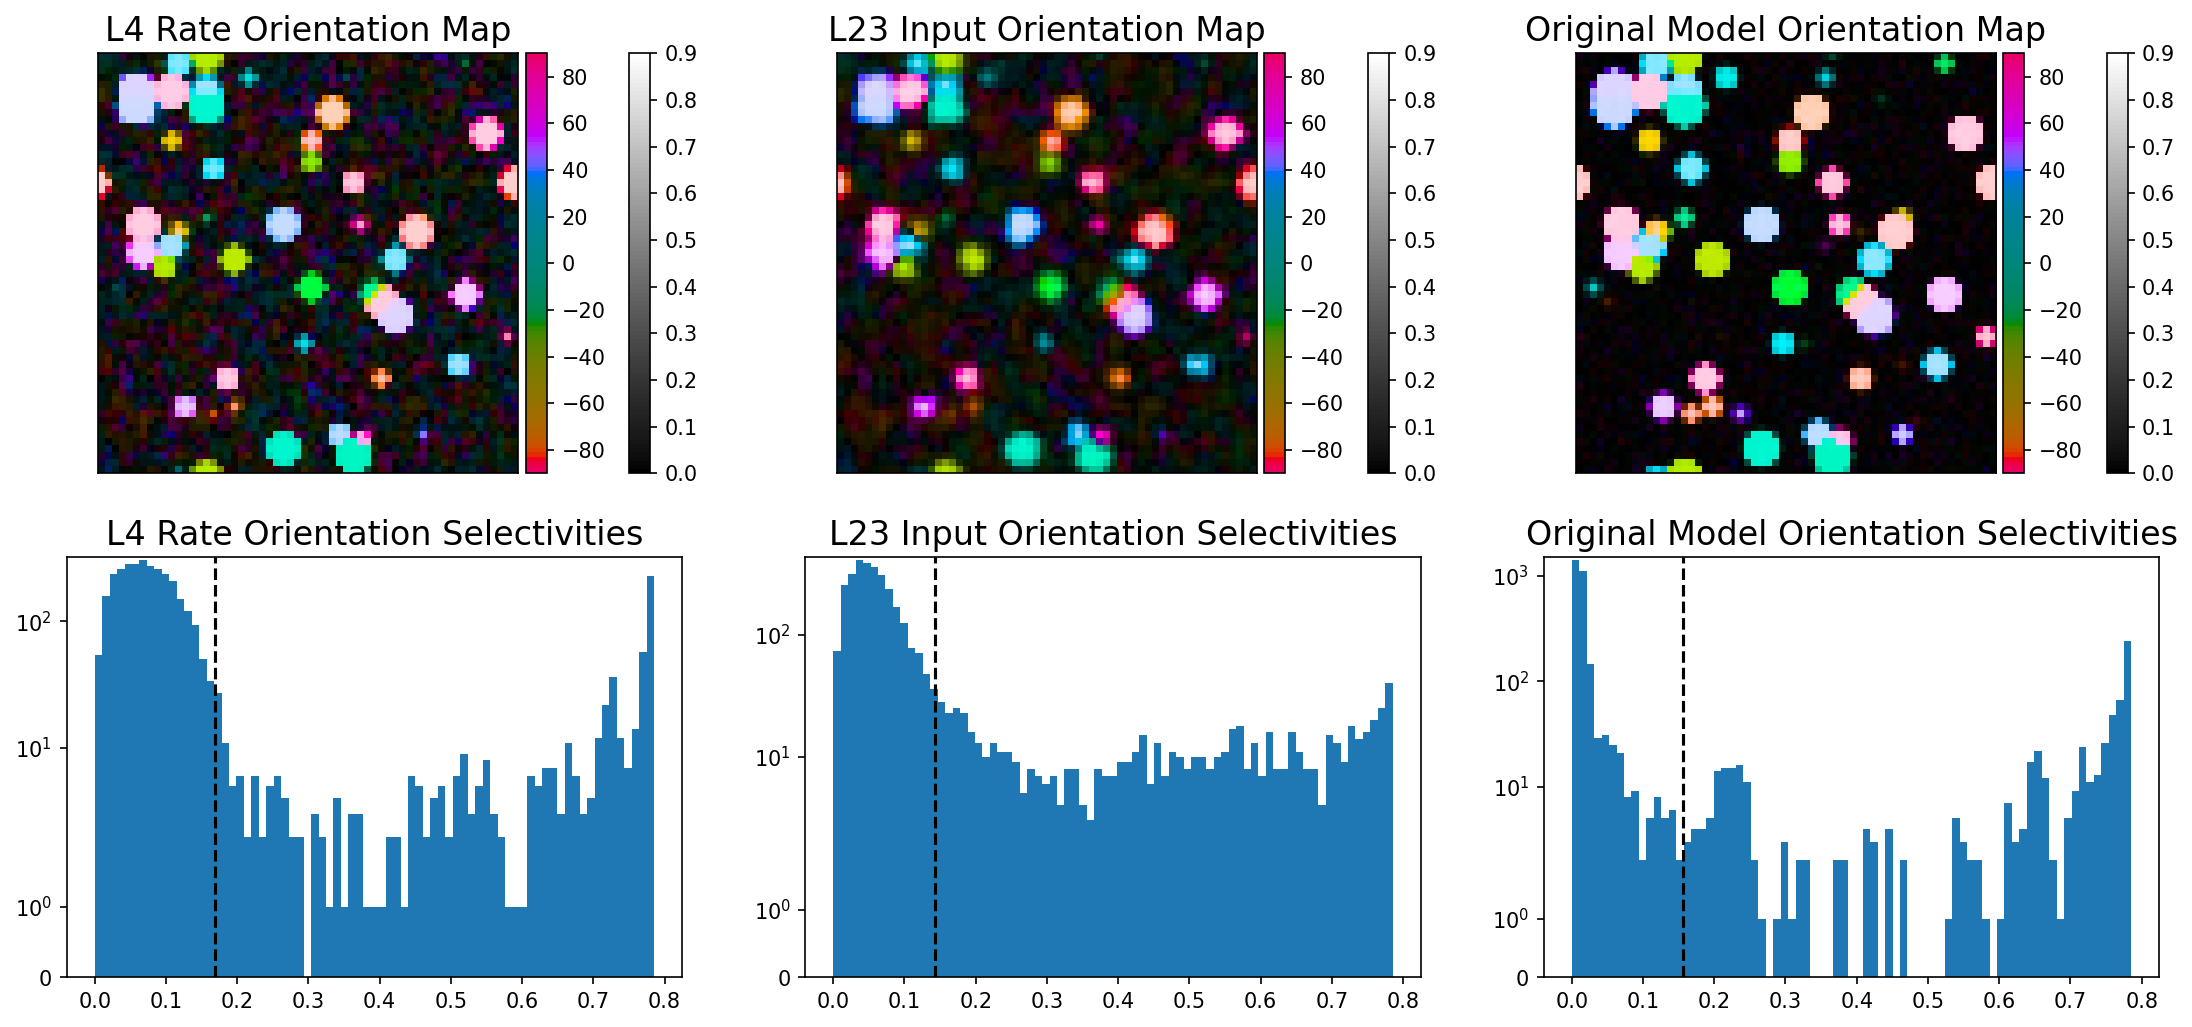

In [ ]:
fig,axs = plt.subplots(2,3,figsize=(18,8),dpi=150)

pf.domcolbar(fig,axs[0,0],L4_z,origin='lower',alim=[-90,90],rlim=[0,0.9])
pf.domcolbar(fig,axs[0,1],L23_z,origin='lower',alim=[-90,90],rlim=[0,0.9])
pf.domcolbar(fig,axs[0,2],sim_L23_input_z,origin='lower',alim=[-90,90],rlim=[0,0.9])
axs[1,0].hist(np.abs(L4_z).flatten(),np.linspace(0,np.pi/4,76))
axs[1,0].axvline(np.mean(np.abs(L4_z)),c='k',ls='--')
axs[1,1].hist(np.abs(L23_z).flatten(),np.linspace(0,np.pi/4,76))
axs[1,1].axvline(np.mean(np.abs(L23_z)),c='k',ls='--')
axs[1,2].hist(np.abs(sim_L23_input_z).flatten(),np.linspace(0,np.pi/4,76))
axs[1,2].axvline(np.mean(np.abs(sim_L23_input_z)),c='k',ls='--')

axs[1,0].set_yscale('symlog')
axs[1,1].set_yscale('symlog')
axs[1,2].set_yscale('symlog')

axs[0,0].set_title('L4 Rate Orientation Map',fontsize=16)
axs[0,1].set_title('L23 Input Orientation Map',fontsize=16)
axs[0,2].set_title('Original Model Orientation Map',fontsize=16)
axs[1,0].set_title('L4 Rate Orientation Selectivities',fontsize=16)
axs[1,1].set_title('L23 Input Orientation Selectivities',fontsize=16)
axs[1,2].set_title('Original Model Orientation Selectivities',fontsize=16)

print('Mean S&P OS =',np.mean(np.abs(L4_z)))
print('Mean Smoothed OS =',np.mean(np.abs(L23_z)))

Text(0.5, 1.0, 'Original Model Orientation Selectivity')

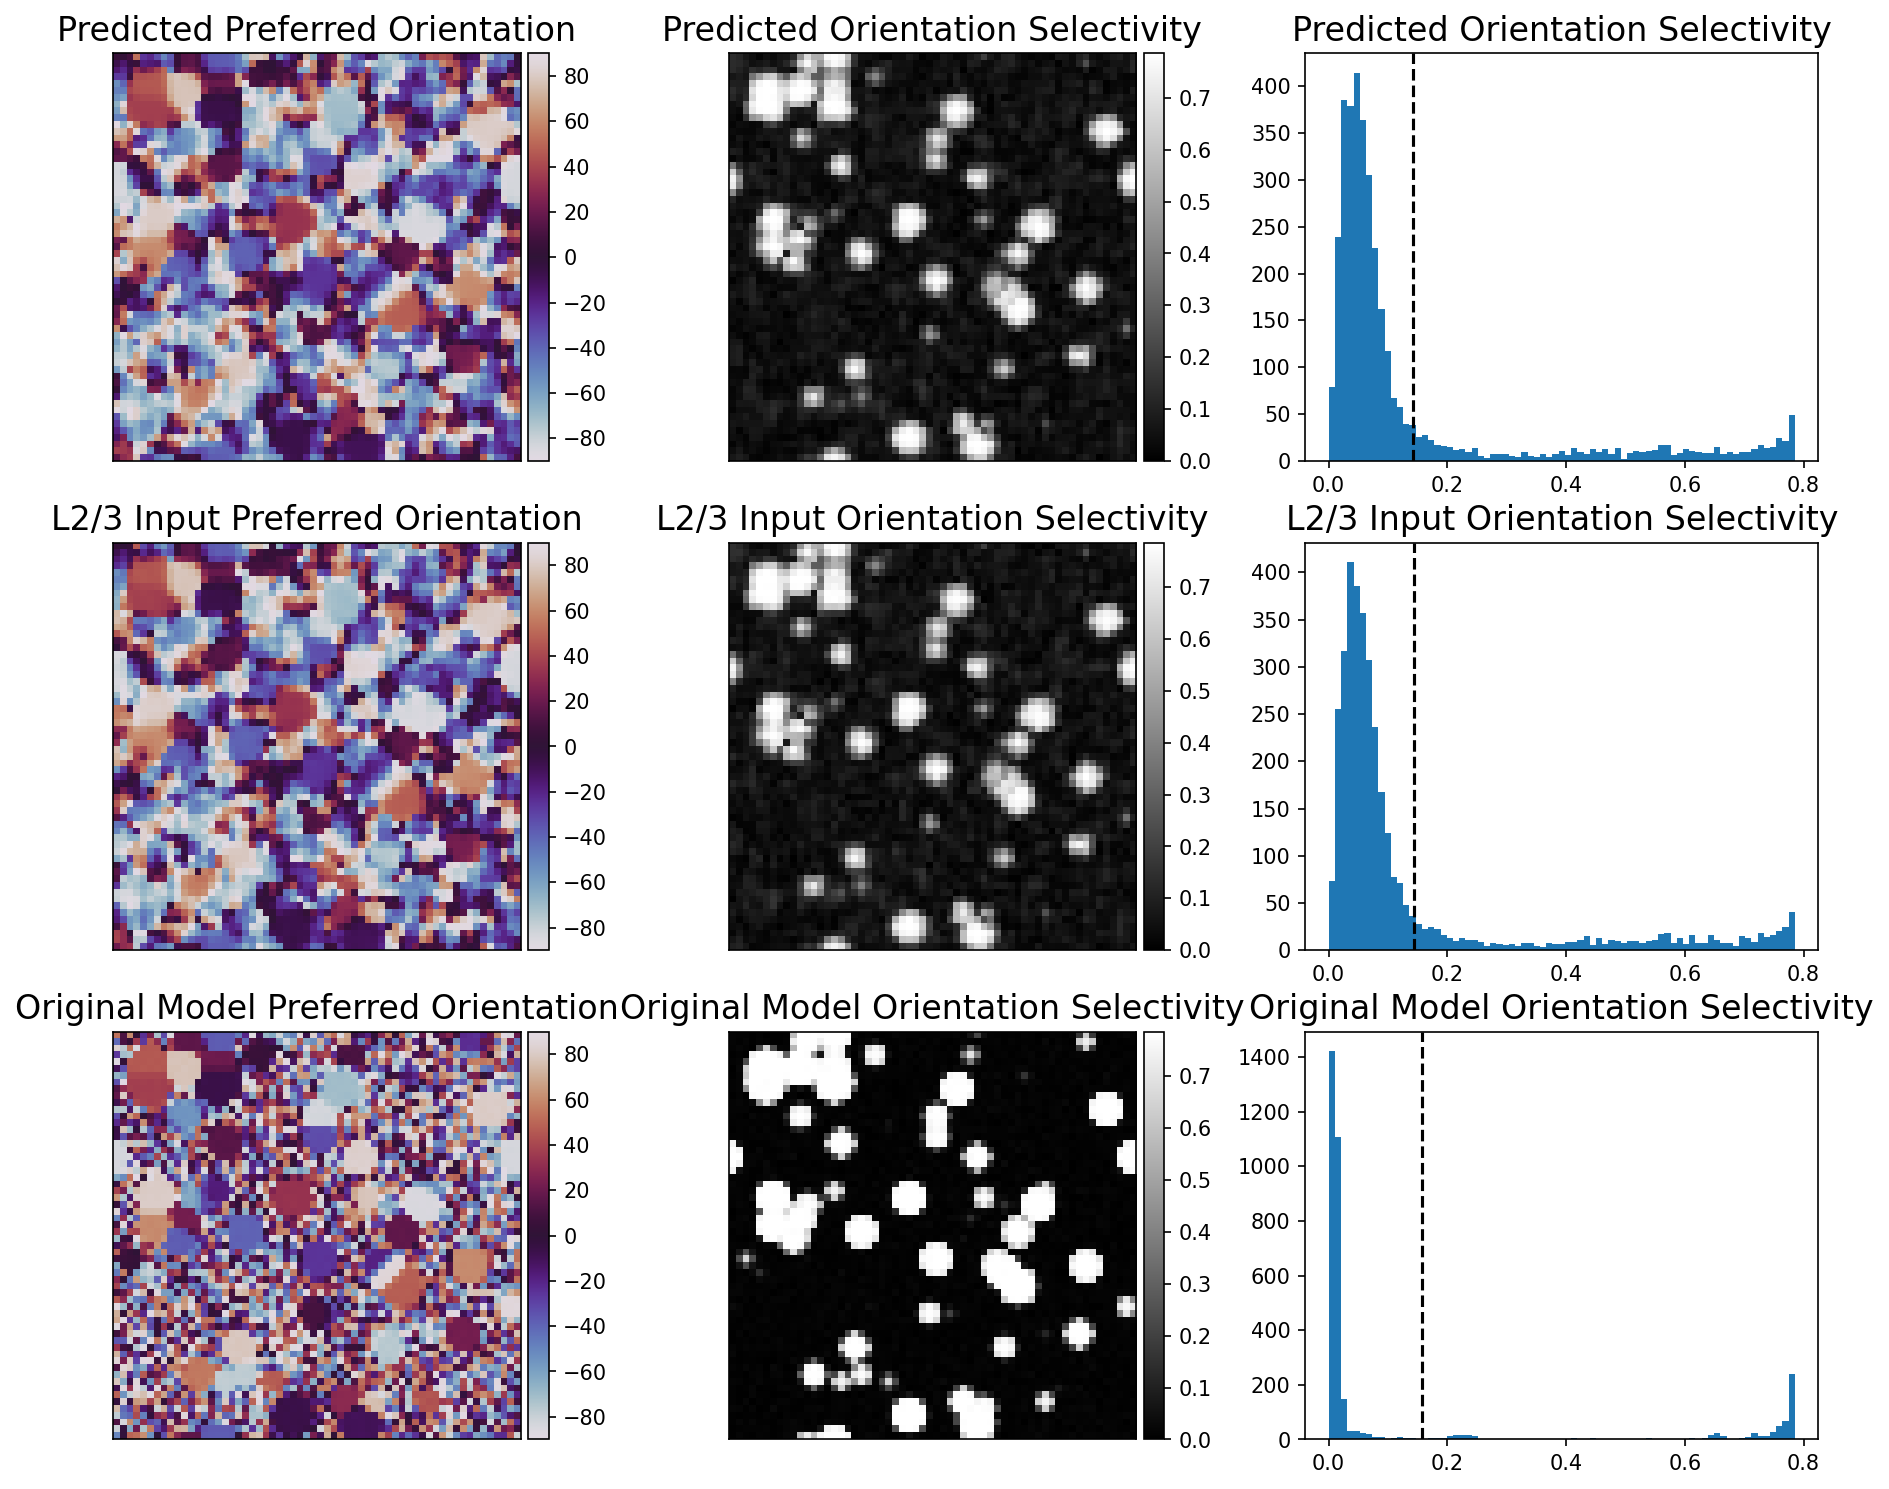

In [ ]:
fig,axs = plt.subplots(3,3,figsize=(15,12),dpi=150)

pf.imshowbar(fig,axs[0,0],np.angle(WL4_z)*180/(2*np.pi),origin='lower',cmap='twilight',vmin=-90,vmax=90)

pf.imshowbar(fig,axs[0,1],np.abs(WL4_z),origin='lower',cmap='binary_r',
             vmin=0,vmax=np.pi/4)

axs[0,2].hist(np.abs(WL4_z).flatten(),np.linspace(0,np.pi/4,76))
axs[0,2].axvline(np.mean(np.abs(WL4_z)),c='k',ls='--')

pf.imshowbar(fig,axs[1,0],np.angle(L23_z)*180/(2*np.pi),origin='lower',cmap='twilight',vmin=-90,vmax=90)

pf.imshowbar(fig,axs[1,1],np.abs(L23_z),origin='lower',cmap='binary_r',
             vmin=0,vmax=np.pi/4)

axs[1,2].hist(np.abs(L23_z).flatten(),np.linspace(0,np.pi/4,76))
axs[1,2].axvline(np.mean(np.abs(L23_z)),c='k',ls='--')

pf.imshowbar(fig,axs[2,0],np.angle(sim_L23_input_z)*180/(2*np.pi),origin='lower',cmap='twilight',vmin=-90,vmax=90)

pf.imshowbar(fig,axs[2,1],np.abs(sim_L23_input_z),origin='lower',cmap='binary_r',
             vmin=0,vmax=np.pi/4)

axs[2,2].hist(np.abs(sim_L23_input_z).flatten(),np.linspace(0,np.pi/4,76))
axs[2,2].axvline(np.mean(np.abs(sim_L23_input_z)),c='k',ls='--')

axs[0,0].set_title('Predicted Preferred Orientation',fontsize=16)
axs[0,1].set_title('Predicted Orientation Selectivity',fontsize=16)
axs[0,2].set_title('Predicted Orientation Selectivity',fontsize=16)
axs[1,0].set_title('L2/3 Input Preferred Orientation',fontsize=16)
axs[1,1].set_title('L2/3 Input Orientation Selectivity',fontsize=16)
axs[1,2].set_title('L2/3 Input Orientation Selectivity',fontsize=16)
axs[2,0].set_title('Original Model Preferred Orientation',fontsize=16)
axs[2,1].set_title('Original Model Orientation Selectivity',fontsize=16)
axs[2,2].set_title('Original Model Orientation Selectivity',fontsize=16)

In [ ]:
opm_mismatch = np.abs(L23_PO - np.angle(sim_L23_rate_z[0]) * 180/(2*np.pi))
opm_mismatch[opm_mismatch > 90] = 180 - opm_mismatch[opm_mismatch > 90]

sim_opm_mismatch = np.abs(np.angle(sim_L23_input_z) - np.angle(sim_L23_rate_z[0])) * 180/(2*np.pi)
sim_opm_mismatch[sim_opm_mismatch > 90] = 180 - sim_opm_mismatch[sim_opm_mismatch > 90]

34.64235029766115
33.553553031216886


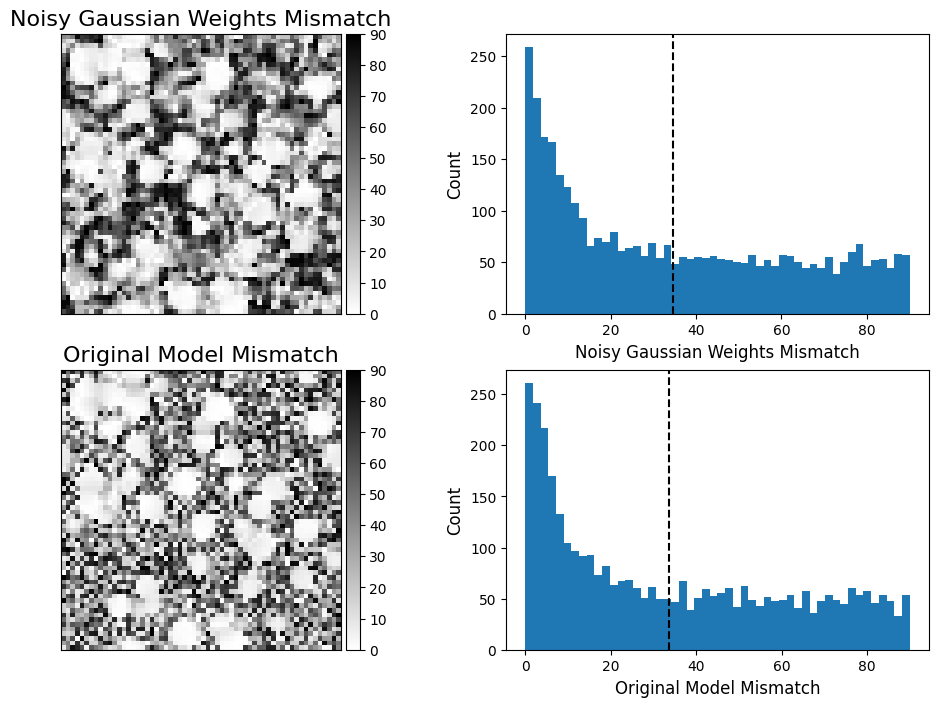

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(12,8))

pf.imshowbar(fig,axs[0,0],opm_mismatch,
             origin='lower',cmap='binary',vmin=0,vmax=90)
axs[0,1].hist(opm_mismatch.flatten(),50)
axs[0,1].axvline(np.mean(opm_mismatch),c='k',ls='--')

pf.imshowbar(fig,axs[1,0],sim_opm_mismatch,
             origin='lower',cmap='binary',vmin=0,vmax=90)
axs[1,1].hist(sim_opm_mismatch.flatten(),50)
axs[1,1].axvline(np.mean(sim_opm_mismatch),c='k',ls='--')

axs[0,0].set_title('Noisy Gaussian Weights Mismatch',fontsize=16)
axs[0,1].set_xlabel('Noisy Gaussian Weights Mismatch',fontsize=12)
axs[0,1].set_ylabel('Count',fontsize=12)
axs[1,0].set_title('Original Model Mismatch',fontsize=16)
axs[1,1].set_xlabel('Original Model Mismatch',fontsize=12)
axs[1,1].set_ylabel('Count',fontsize=12)

print(np.mean(opm_mismatch))
print(np.mean(sim_opm_mismatch))

# Build RFs for L4

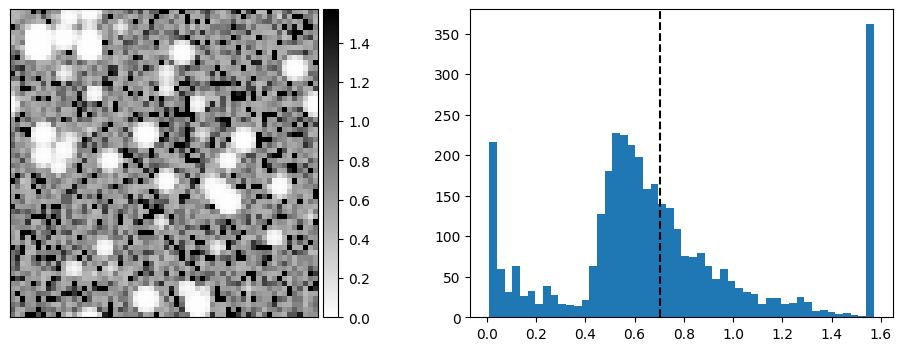

In [ ]:
L4_phis = RF_OS_inv_itp(np.fmax(min_OS,np.abs(L4_z)))

fig,axs = plt.subplots(1,2,figsize=(12,4))

pf.imshowbar(fig,axs[0],L4_phis,
             origin='lower',cmap='binary',vmin=0,vmax=np.pi/2)
axs[1].hist(L4_phis.flatten(),50)
axs[1].axvline(np.mean(L4_phis),c='k',ls='--')

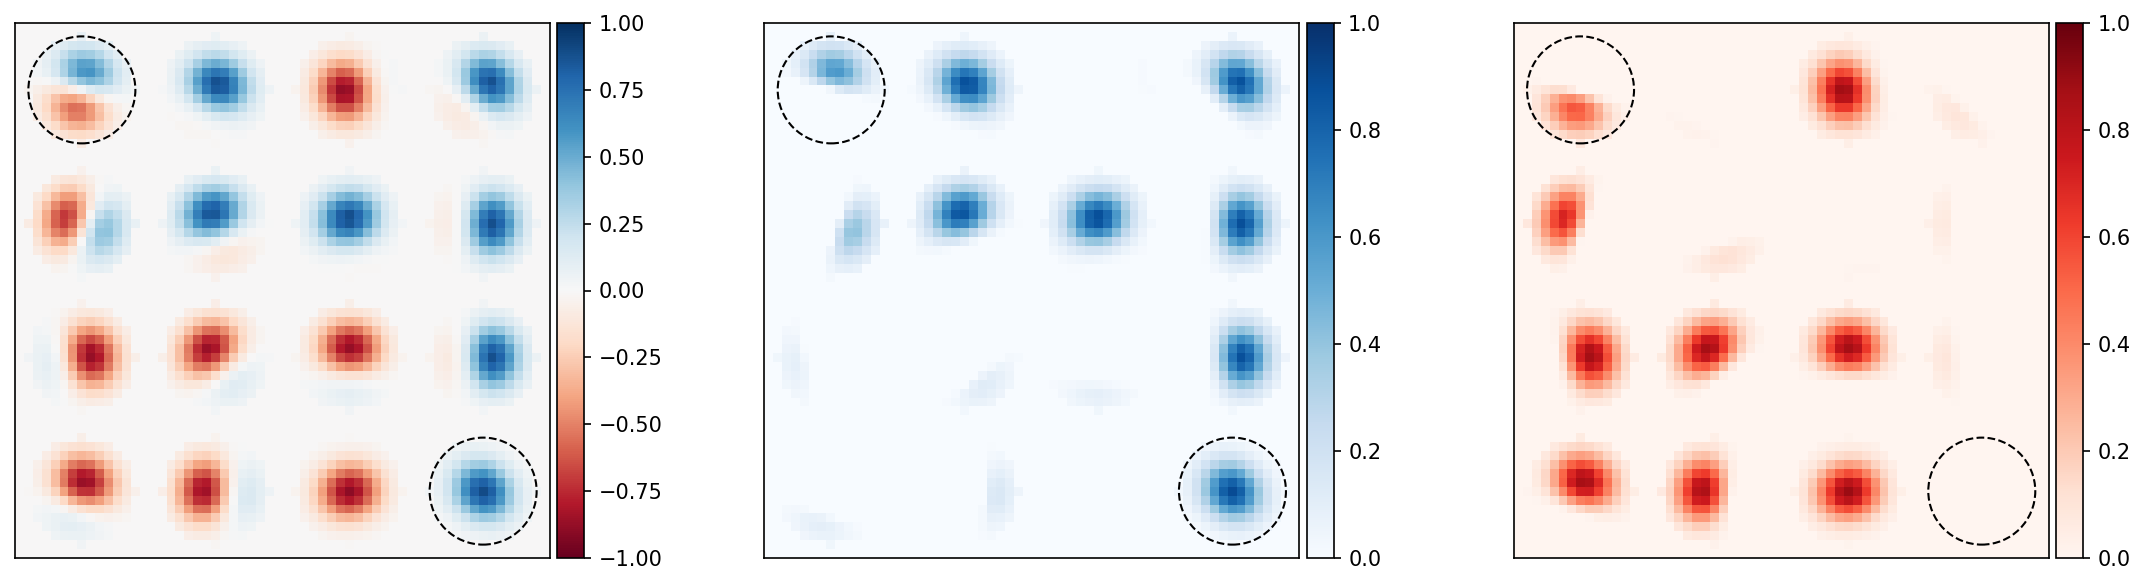

In [ ]:
σ = 0.04
k = 0.5/σ
xs,ys = np.meshgrid(np.arange(N)/N,np.arange(N)/N)
xs[xs > 0.5] = xs[xs > 0.5] - 1
ys[ys > 0.5] = ys[ys > 0.5] - 1
ds = np.sqrt(xs**2 + ys**2)

def sq_gabor(ori,phi):
    return np.exp(-0.5*(xs**2+ys**2)/σ**2)*np.sin(k*(np.cos(ori*2*np.pi/180)*xs+np.sin(ori*2*np.pi/180)*ys)+phi)/np.sqrt(np.sin(phi)**2+(k*σ)**2)#np.sin(k*σ+phi)

RFs = np.zeros((N,N,N,N))
rng = np.random.default_rng(0)
for i in range(N):
    for j in range(N):
        this_rf = rng.choice([1,-1])*sq_gabor(np.angle(L4_z[i,j])*180/(2*np.pi),rng.choice([1,-1])*L4_phis[i,j])
        this_rf[ds > 2.5*σ] = 0
        RFs[i,j] = np.roll(this_rf,(i,j),(0,1))
        
on_conn = np.zeros_like(RFs)
of_conn = np.zeros_like(RFs)

on_conn[RFs > 0] = RFs[RFs > 0]
of_conn[RFs < 0] = -RFs[RFs < 0]
        
fig,axs = plt.subplots(1,3,figsize=(15,4),dpi=150)
nshow = 4

RF_sum = np.zeros((N,N))
for i in range(N//nshow//2,N,N//nshow):
    for j in range(N//nshow//2,N,N//nshow):
        RF_sum += RFs[i,j]
pf.imshowbar(fig,axs[0],RF_sum,cmap='RdBu',origin='lower',vmin=-1,vmax=1)

on_sum = np.zeros((N,N))
of_sum = np.zeros((N,N))
for i in range(N//nshow//2,N,N//nshow):
    for j in range(N//nshow//2,N,N//nshow):
        on_sum += on_conn[i,j]
        of_sum += of_conn[i,j]
pf.imshowbar(fig,axs[1],on_sum,cmap='Blues',origin='lower',vmin=0,vmax=1)
pf.imshowbar(fig,axs[2],of_sum,cmap='Reds',origin='lower',vmin=0,vmax=1)

for i in range(N//nshow//2,N,N//nshow):
    for j in range(N//nshow//2,N,N//nshow):
        if np.abs(i - j) != range(N//nshow//2,N,N//nshow)[-1] - range(N//nshow//2,N,N//nshow)[0]:
            continue
        axs[0].add_patch(plt.Circle((i,j),2.5*σ*N, color='k', ls='--', fill=False))
        axs[1].add_patch(plt.Circle((i,j),2.5*σ*N, color='k', ls='--', fill=False))
        axs[2].add_patch(plt.Circle((i,j),2.5*σ*N, color='k', ls='--', fill=False))

fig.tight_layout()
fig.savefig('./../plots/LGN Model.pdf')

# Test Responses of L4 RFs to Drifting Gratings

In [ ]:
# Save LGN weights to a file to run probe_RFs on
WTto4 = np.zeros((4,N**2,N**2))
WTto4[0] = on_conn.reshape((N**2,N**2))
WTto4[1] = of_conn.reshape((N**2,N**2))
WTto4[2] = on_conn.reshape((N**2,N**2))
WTto4[3] = of_conn.reshape((N**2,N**2))

data_dict = {"W" : WTto4}

config_name = 'lempel_big_L4_model'
v = 0
config_dict,N4pop,NTpop,NR,NT,N4,rA = uf.get_network_size(config_name)

if not os.path.exists(data_dir + "layer4/{s}".format(s=config_name)):
    os.makedirs(data_dir + "layer4/{s}".format(s=config_name))
if not os.path.exists(data_dir + "layer4/{s}/v{v}".format(s=config_name,v=v)):
    os.makedirs(data_dir + "layer4/{s}/v{v}".format(s=config_name,v=v))
    
filename = "layer4/{s}/v{v}/y_v{v}.npz".format(s=config_name,v=v)
misc.save_data(v,filename, data_dict)

filename = "layer4/{s}/v{v}/config_v{v}".format(s=config_dict["config_name"],v=v)
misc.save_params(v,filename,config_dict)

MISC params_dict params_lempel_big_L4_model {'Nret': 60, 'Nlgn': 60, 'N4': 60, 'N23': 1, 'Nvert': 1, 'runtime': 16000, 'dt': 0.05, 'tau': 1.0, 'num_lgn_paths': 4, 'gamma_lgn': 4.0, 'gamma_4': 1.0, 'gamma_23': 1.0, 'learning_rate_decay_const': 160000.0, 'saving_stepsize': 10, 'plasticity_rule': 'activity_based', 'random_seed': 19, 'nonlinearity_l4': 'rectifier', 'nonlinearity_l23': 'rectifier', 'integrator': 'Euler', 'test_lowDsubset': False, 'developing_params': [], 'Inp_params': {'ndim': 25, 'radius': 3.0, 'width': 1.0, 'simulate_activity': 'dynamics', 'pattern_duration': 2500, 'avg_no_inp': 1, 'expanse_time': 1, 'init_radius': 0.3, 'mean_width': 0.3, 'onoff_corr_factor': 1.0, 'onoff_rel_weight': 1.0, 'input_type': 'white_noise_online', 'off_bias_strength': 0.0, 'off_bias_region_size': 0.5}, 'Wret_to_lgn_params': {'sigma1': 0.0225, 'sigma2': 0.06, 'ampl1': 2.0, 'ampl2': 1.0, 'gamma_ret': 1.0, 'noise': 0.0, 'sigma': 0.03375, 'ampl': 1.0, 'profile': 'Gaussian', 'mean_eccentricity': 0.6,

In [ ]:
# Calculate preferred spatial frequency
xs,ys = np.meshgrid(np.arange(N),np.arange(N))
xs[xs > N//2] -= N
ys[ys > N//2] -= N
ls = np.sqrt(xs**2+ys**2)
ls_bins = np.digitize(ls,np.arange(0,N//2)+0.5)

σ = 0.04
k = 0.5/σ
xs,ys = np.meshgrid(np.arange(N)/N,np.arange(N)/N)
xs[xs > 0.5] = xs[xs > 0.5] - 1
ys[ys > 0.5] = ys[ys > 0.5] - 1
ds = np.sqrt(xs**2 + ys**2)

sel_RF_fft = np.fft.fft2(sq_gabor(0,0))
sel_RF_fft_mag = np.zeros(N//2)

for i in range(N//2):
    sel_RF_fft_mag[i] = np.max(np.abs(sel_RF_fft[ls_bins == i]))

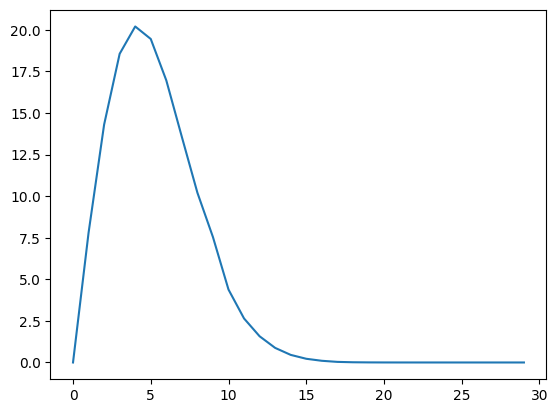

In [ ]:
plt.plot(sel_RF_fft_mag)

In [83]:
reload(probe_RFs)

net,act,phase = probe_RFs.probe_RFs_one_layer(v,config_name,freqs=N*np.array([4]),oris=np.linspace(0,np.pi,4,endpoint=False),Nsur=4)

mode in get_RFs load_from_external
 
Load ff connection from version 0
 
profile_conn Gaussian
CHECK radius 0.13
arbor (60, 60, 60, 60)
CHECK radius 0.13
arbor (60, 60, 60, 60)
CHECK radius 0.13
arbor (60, 60, 60, 60)
CHECK radius 0.13
arbor (60, 60, 60, 60)

CHECK CONN VALS Gaussian 0.9788211066988415 0.9523664821934675 1.7539524943521199 9.165528607381239
orig max ew 4.690020432938895 0.9
max_ew 0.9
WEE=4.260109371736784,WEI=4.144971280608765,WIE=4.144971280608764,WII=3.991453825771403
omega_i=Wie-Wee=-0.11513809112802065
omega_e=Wii-Wei=-0.15351745483736146

mode in generate_inputs moving_grating_online
lgn (2, 3600, 1, 4, 4)
(2, 1, 3600, 4, 4)
(2, 3600, 4, 4, 1)
(2, 3600, 4, 1, 4)
(2, 3600, 1, 4, 4)
Wlgn_to_4 (4, 3600, 3600) (2, 3600, 1, 4, 4)
It (2001, 7200) (2001, 7200)
temp_freq 1
pref_phase 6.278996516974799 0.0
pref_phase 6.278996516974799 0.0
Spat frequency=240, orientation=0 deg 2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


plot done 0.0 240
It (2001, 7200) (2001, 7200)
temp_freq 1
pref_phase 6.278996516974799 0.0
pref_phase 6.278996516974799 0.0
Spat frequency=240, orientation=45 deg 2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


plot done 0.7853981633974483 240
It (2001, 7200) (2001, 7200)
temp_freq 1
pref_phase 6.278996516974799 0.0
pref_phase 6.278996516974799 0.0
Spat frequency=240, orientation=90 deg 2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


plot done 1.5707963267948966 240
It (2001, 7200) (2001, 7200)
temp_freq 1
pref_phase 6.278996516974799 0.0
pref_phase 6.278996516974799 0.0
Spat frequency=240, orientation=135 deg 2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


plot done 2.356194490192345 240


# Create on/off subregion

In [ ]:
def get_axes(c,A):
    a = np.sqrt(A/(c*np.pi))
    b = a*c
    return a,b

def ellipse_fn(a,b):
    def f(x,y):
        return 1 - (x/a)**2 - (y/b)**2
    return f

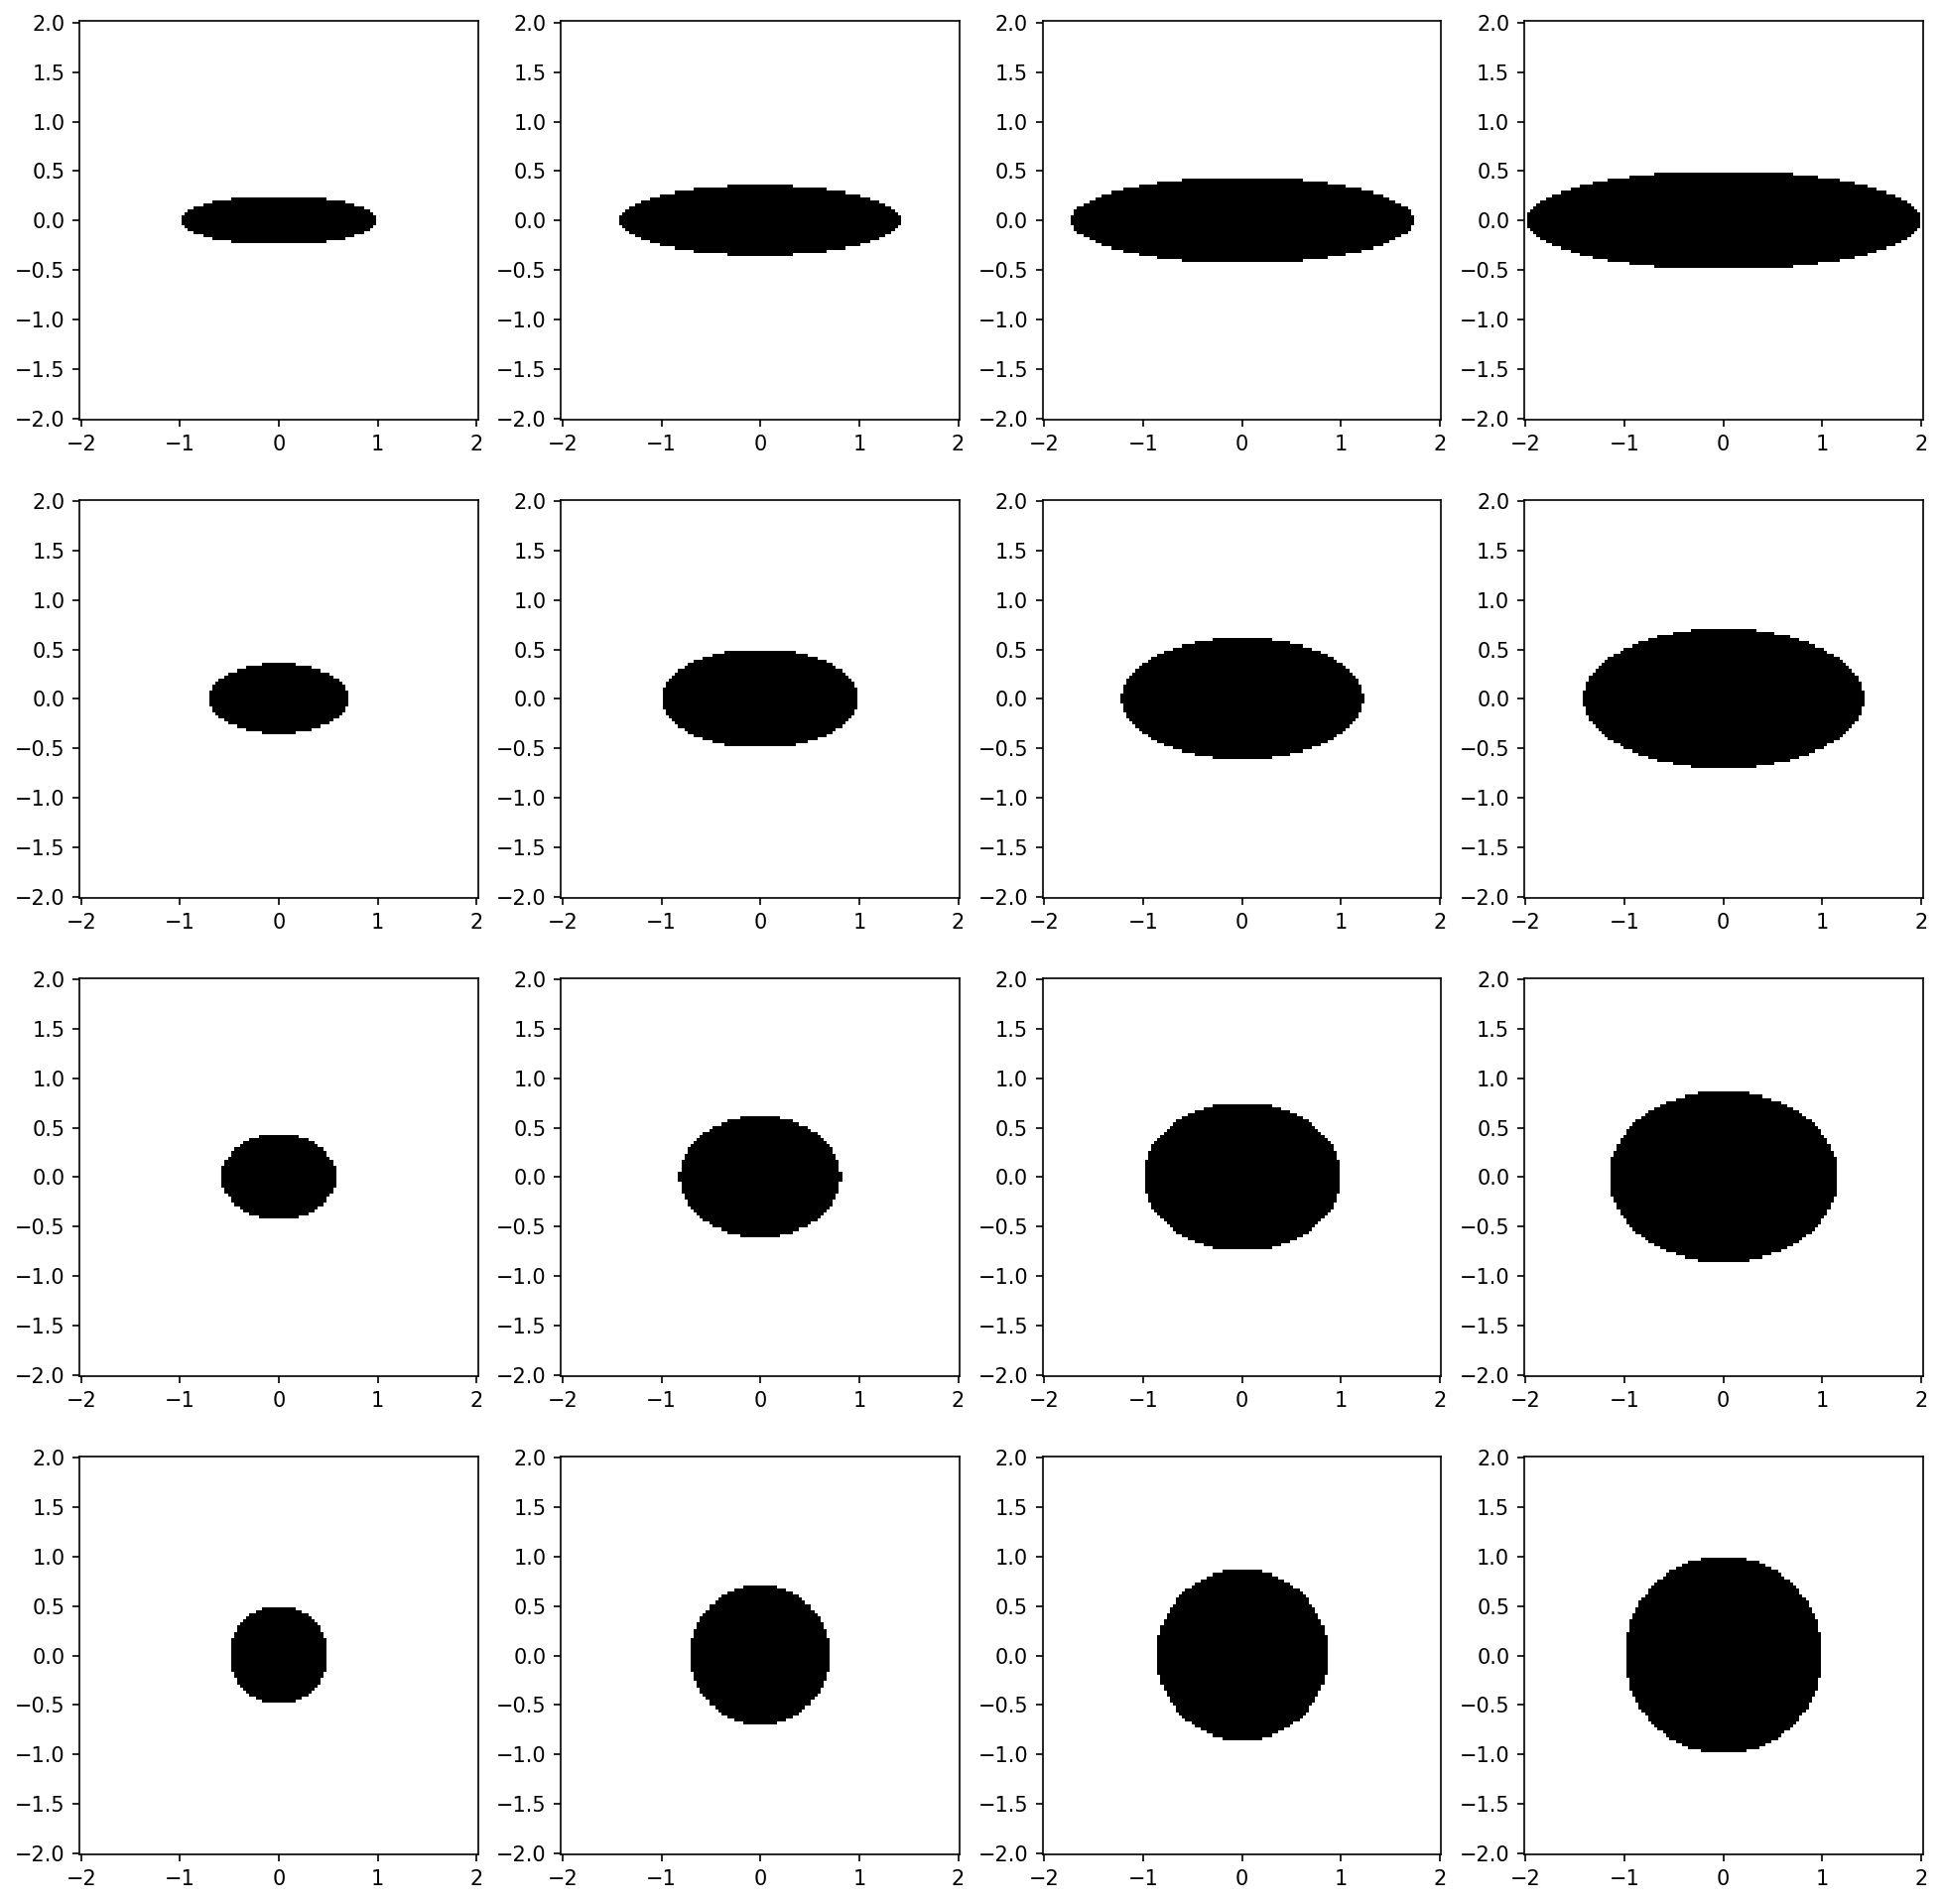

In [ ]:
N = 128
L = 4

pts = np.arange(N+1)*L/N - L/2
x,y = np.meshgrid(pts,pts)
extent = (pts[0]-(L/N)/2,pts[-1]+(L/N)/2,pts[0]-(L/N)/2,pts[-1]+(L/N)/2)

fig,axs = plt.subplots(4,4,figsize=(16,16),dpi=150)

for i,c in enumerate([0.25,0.5,0.75,1]):
    for j,A in enumerate([0.25*np.pi,0.5*np.pi,0.75*np.pi,np.pi]):
        ellipse = (ellipse_fn(*get_axes(c,A))(x,y) > 0).astype(int)

        axs[i,j].imshow(ellipse,cmap='binary',origin='lower',extent=extent)

# Calculate on/off subregion correlation and bias

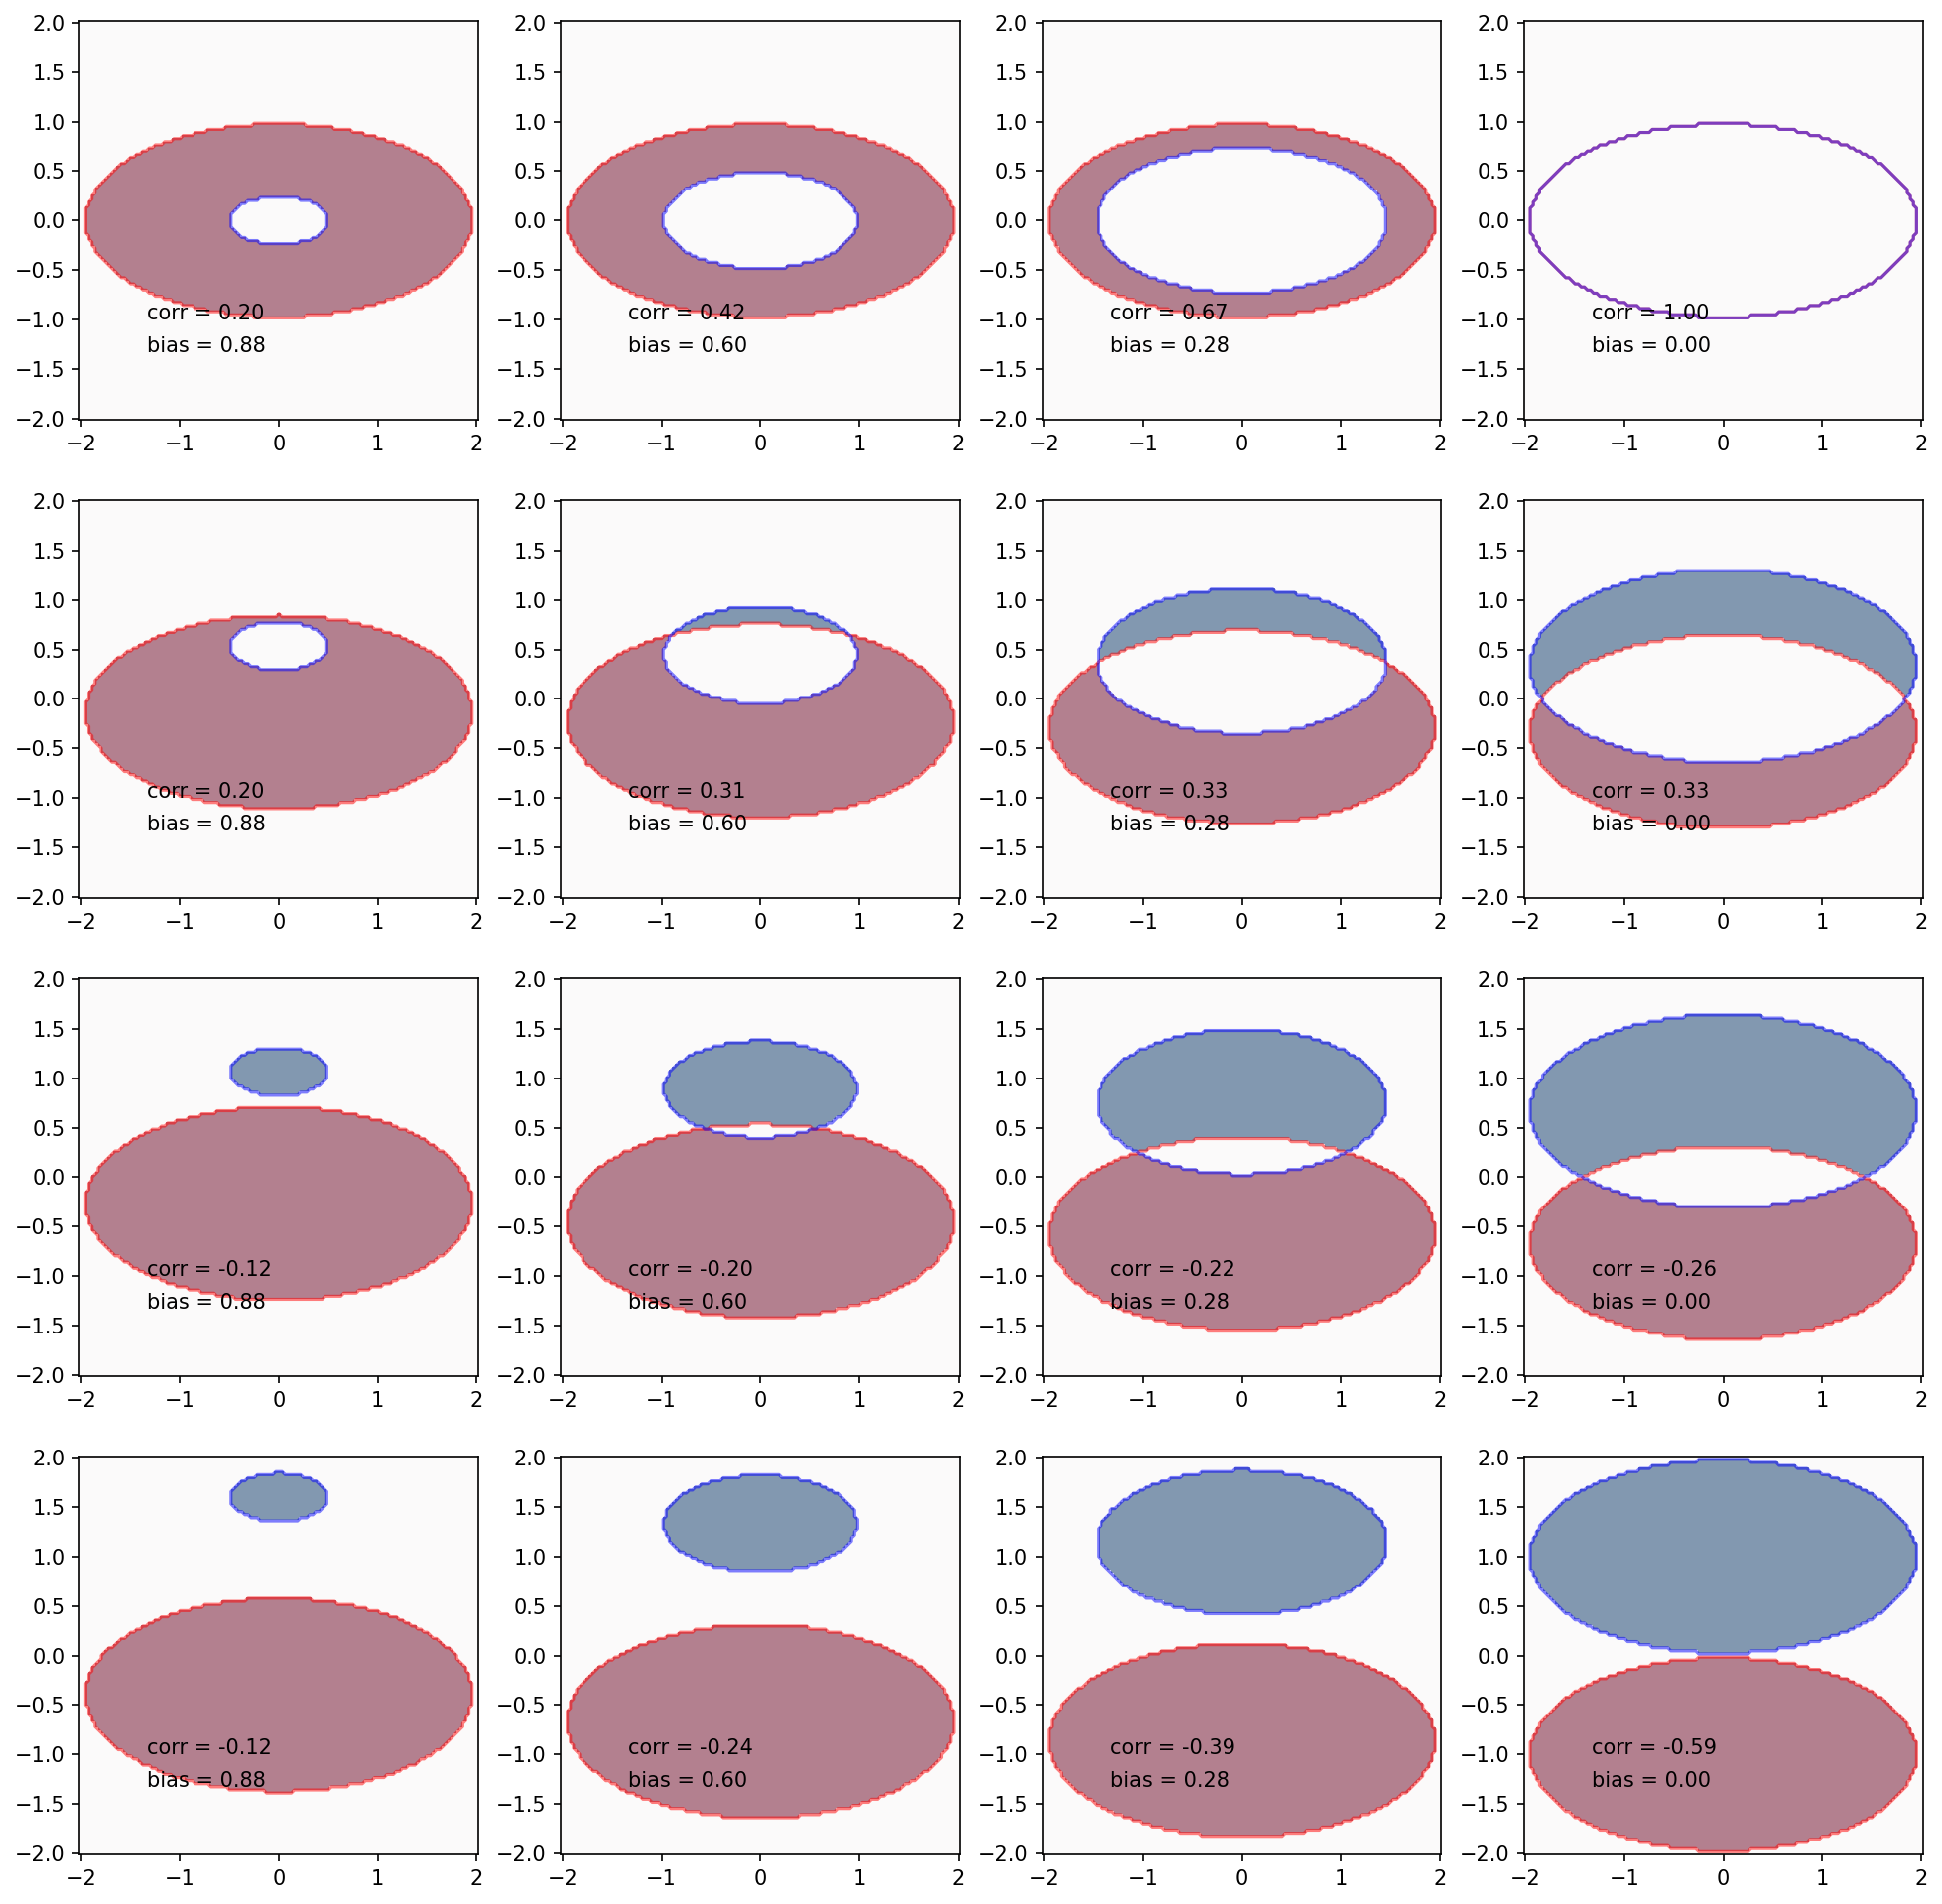

In [ ]:
fig,axs = plt.subplots(4,4,figsize=(16,16),dpi=150)

for i,d in enumerate(np.linspace(0,2,4)):
    for j,r in enumerate([0.25,0.5,0.75,1]):
        ON = (ellipse_fn(*get_axes(0.5,6     ))(x,y+r/(1+r)*d) > 0).astype(int)
        OF = (ellipse_fn(*get_axes(0.5,6*r**2))(x,y-1/(1+r)*d) > 0).astype(int)
        axs[i,j].imshow(ON-OF,origin='lower',extent=extent,cmap='RdBu_r',vmin=-1,vmax=1,alpha=0.5)
        axs[i,j].contour(ON,origin='lower',extent=extent,levels=[0.5],colors='r',alpha=0.5)
        axs[i,j].contour(OF,origin='lower',extent=extent,levels=[0.5],colors='b',alpha=0.5)
    
        corr = np.corrcoef(ON.flatten(),OF.flatten())[0,1]
        bias = np.abs((ON.sum() - OF.sum()) / (ON.sum() + OF.sum()))
        
        axs[i,j].text(-L/3,-L/4,'corr = {:.2f}'.format(corr))
        axs[i,j].text(-L/3,-L/3,'bias = {:.2f}'.format(bias))

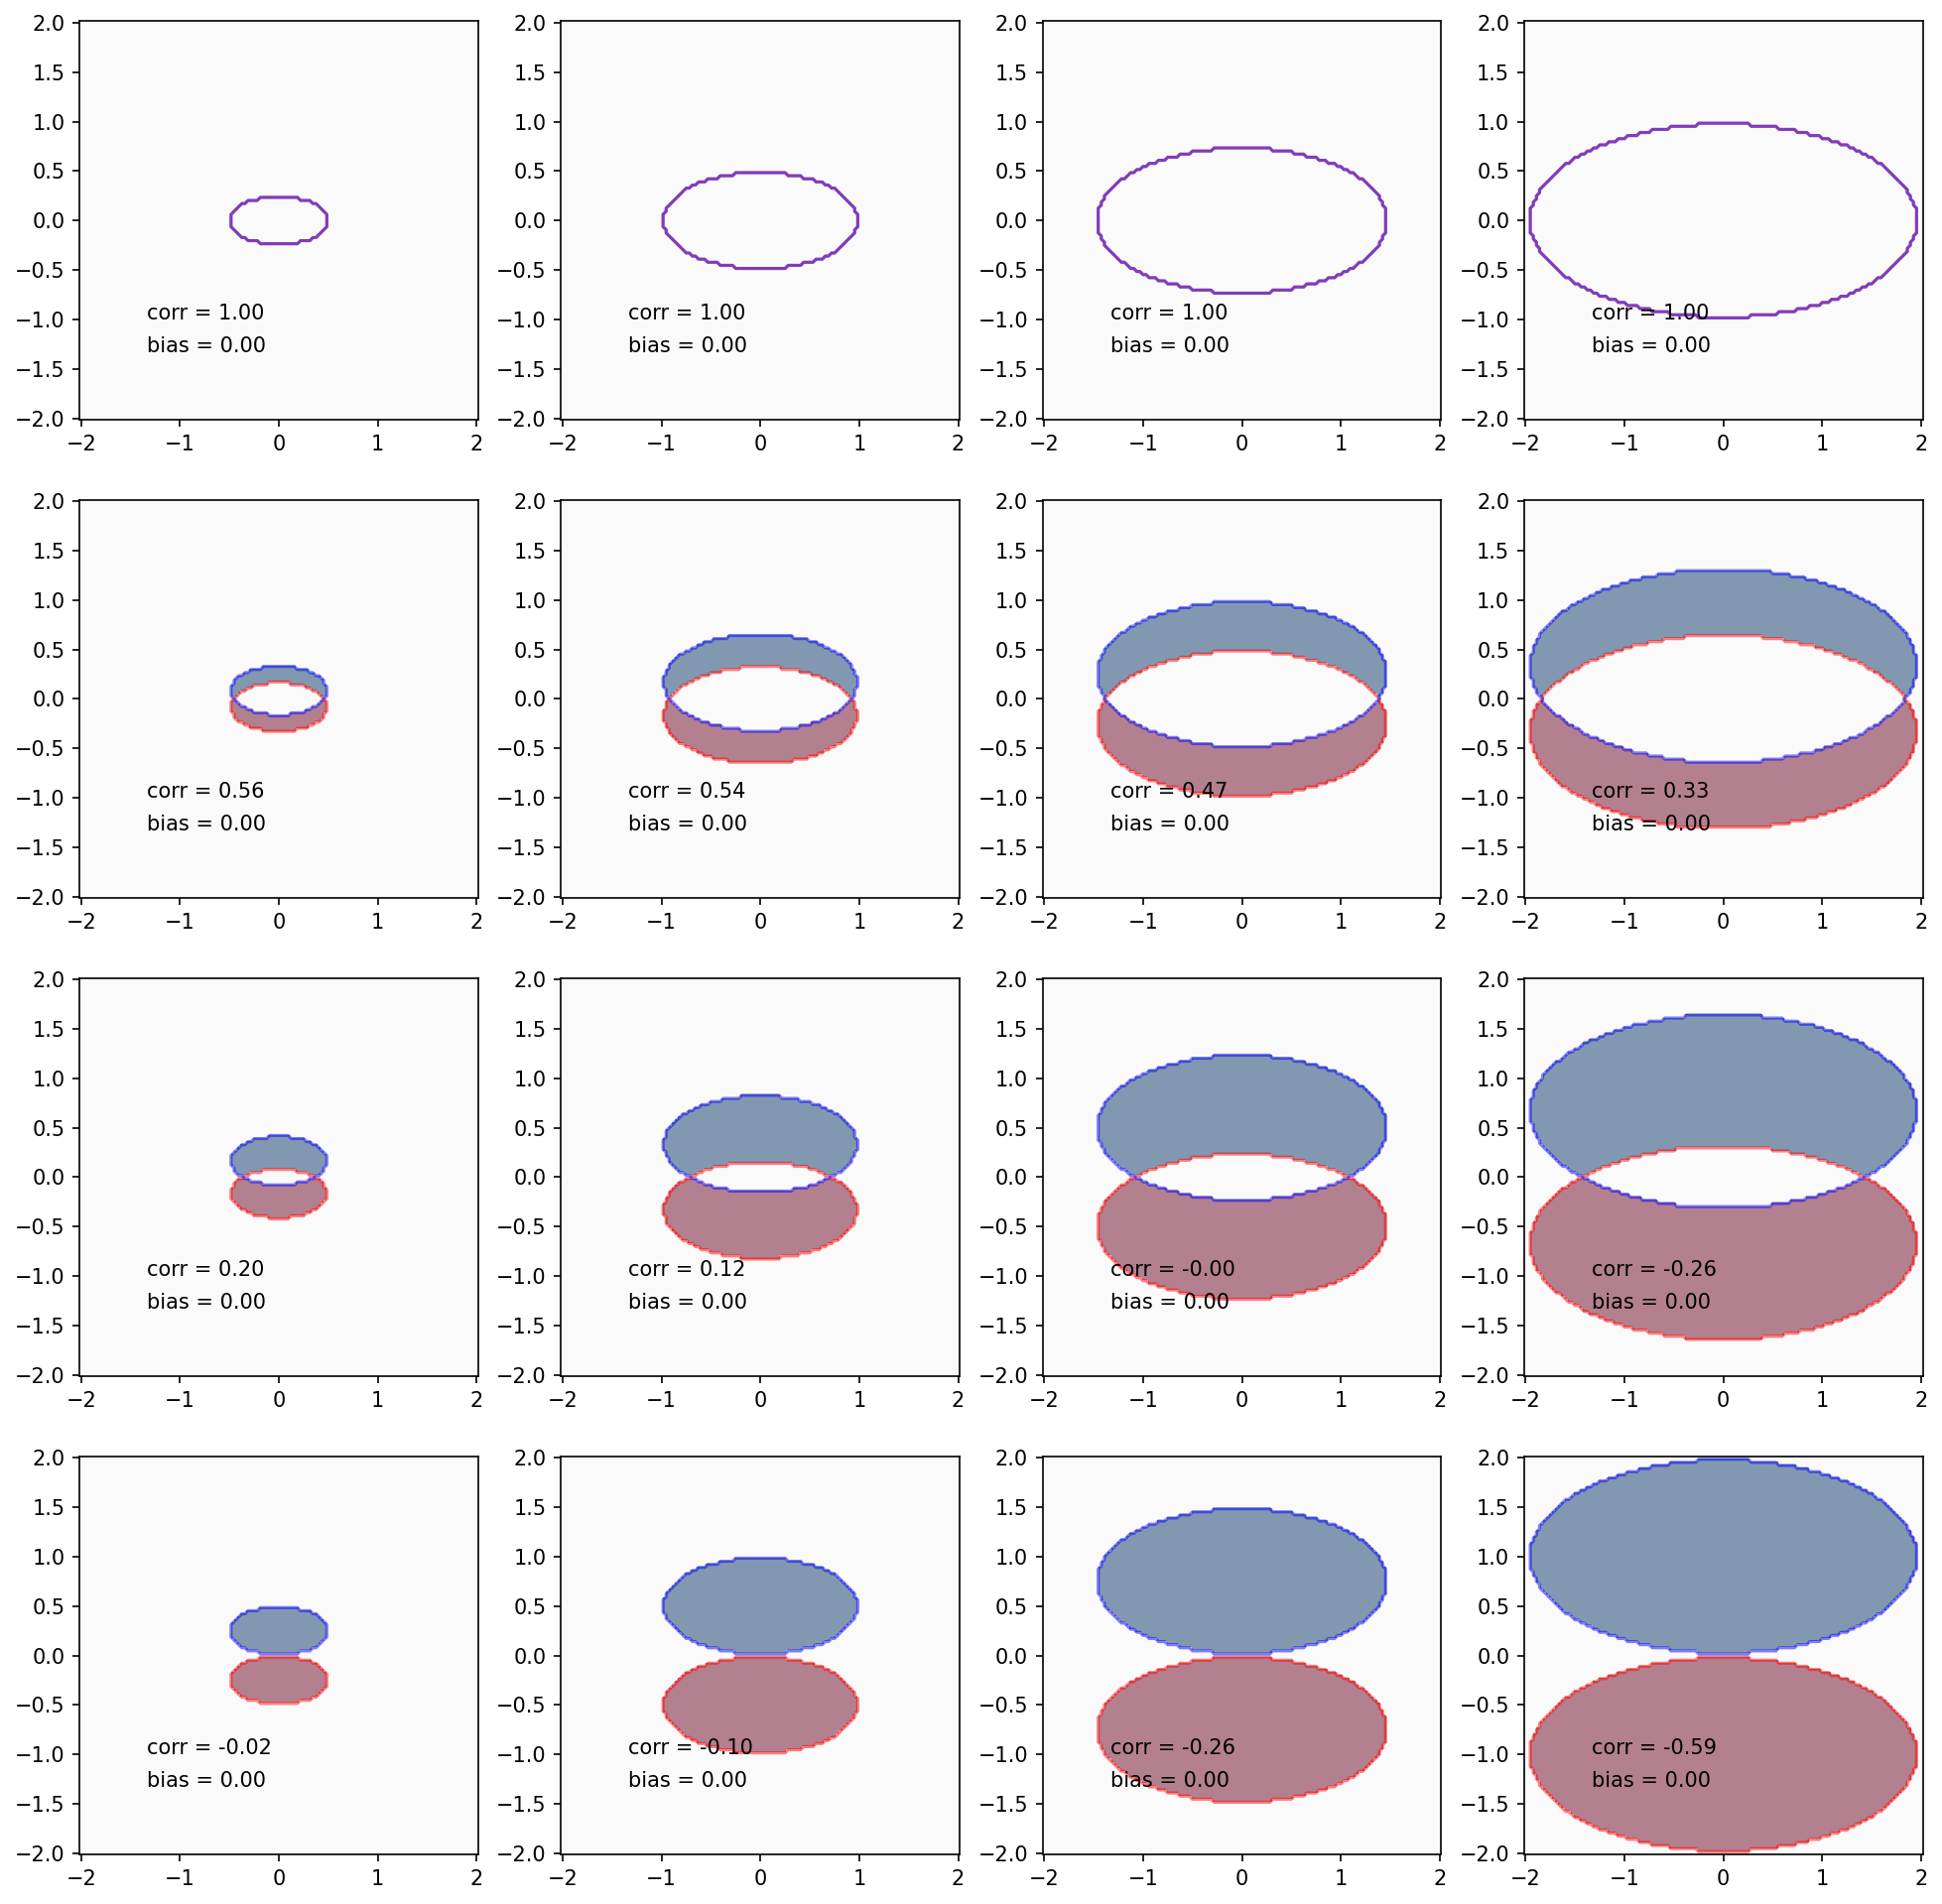

In [ ]:
fig,axs = plt.subplots(4,4,figsize=(16,16),dpi=150)

for i,d in enumerate(np.linspace(0,2,4)):
    for j,s in enumerate([0.25,0.5,0.75,1]):
        ON = (ellipse_fn(*get_axes(0.5,6*s**2))(x,y+d*s/2) > 0).astype(int)
        OF = (ellipse_fn(*get_axes(0.5,6*s**2))(x,y-d*s/2) > 0).astype(int)
        axs[i,j].imshow(ON-OF,origin='lower',extent=extent,cmap='RdBu_r',vmin=-1,vmax=1,alpha=0.5)
        axs[i,j].contour(ON,origin='lower',extent=extent,levels=[0.5],colors='r',alpha=0.5)
        axs[i,j].contour(OF,origin='lower',extent=extent,levels=[0.5],colors='b',alpha=0.5)
    
        corr = np.corrcoef(ON.flatten(),OF.flatten())[0,1]
        bias = np.abs((ON.sum() - OF.sum()) / (ON.sum() + OF.sum()))
        
        axs[i,j].text(-L/3,-L/4,'corr = {:.2f}'.format(corr))
        axs[i,j].text(-L/3,-L/3,'bias = {:.2f}'.format(bias))

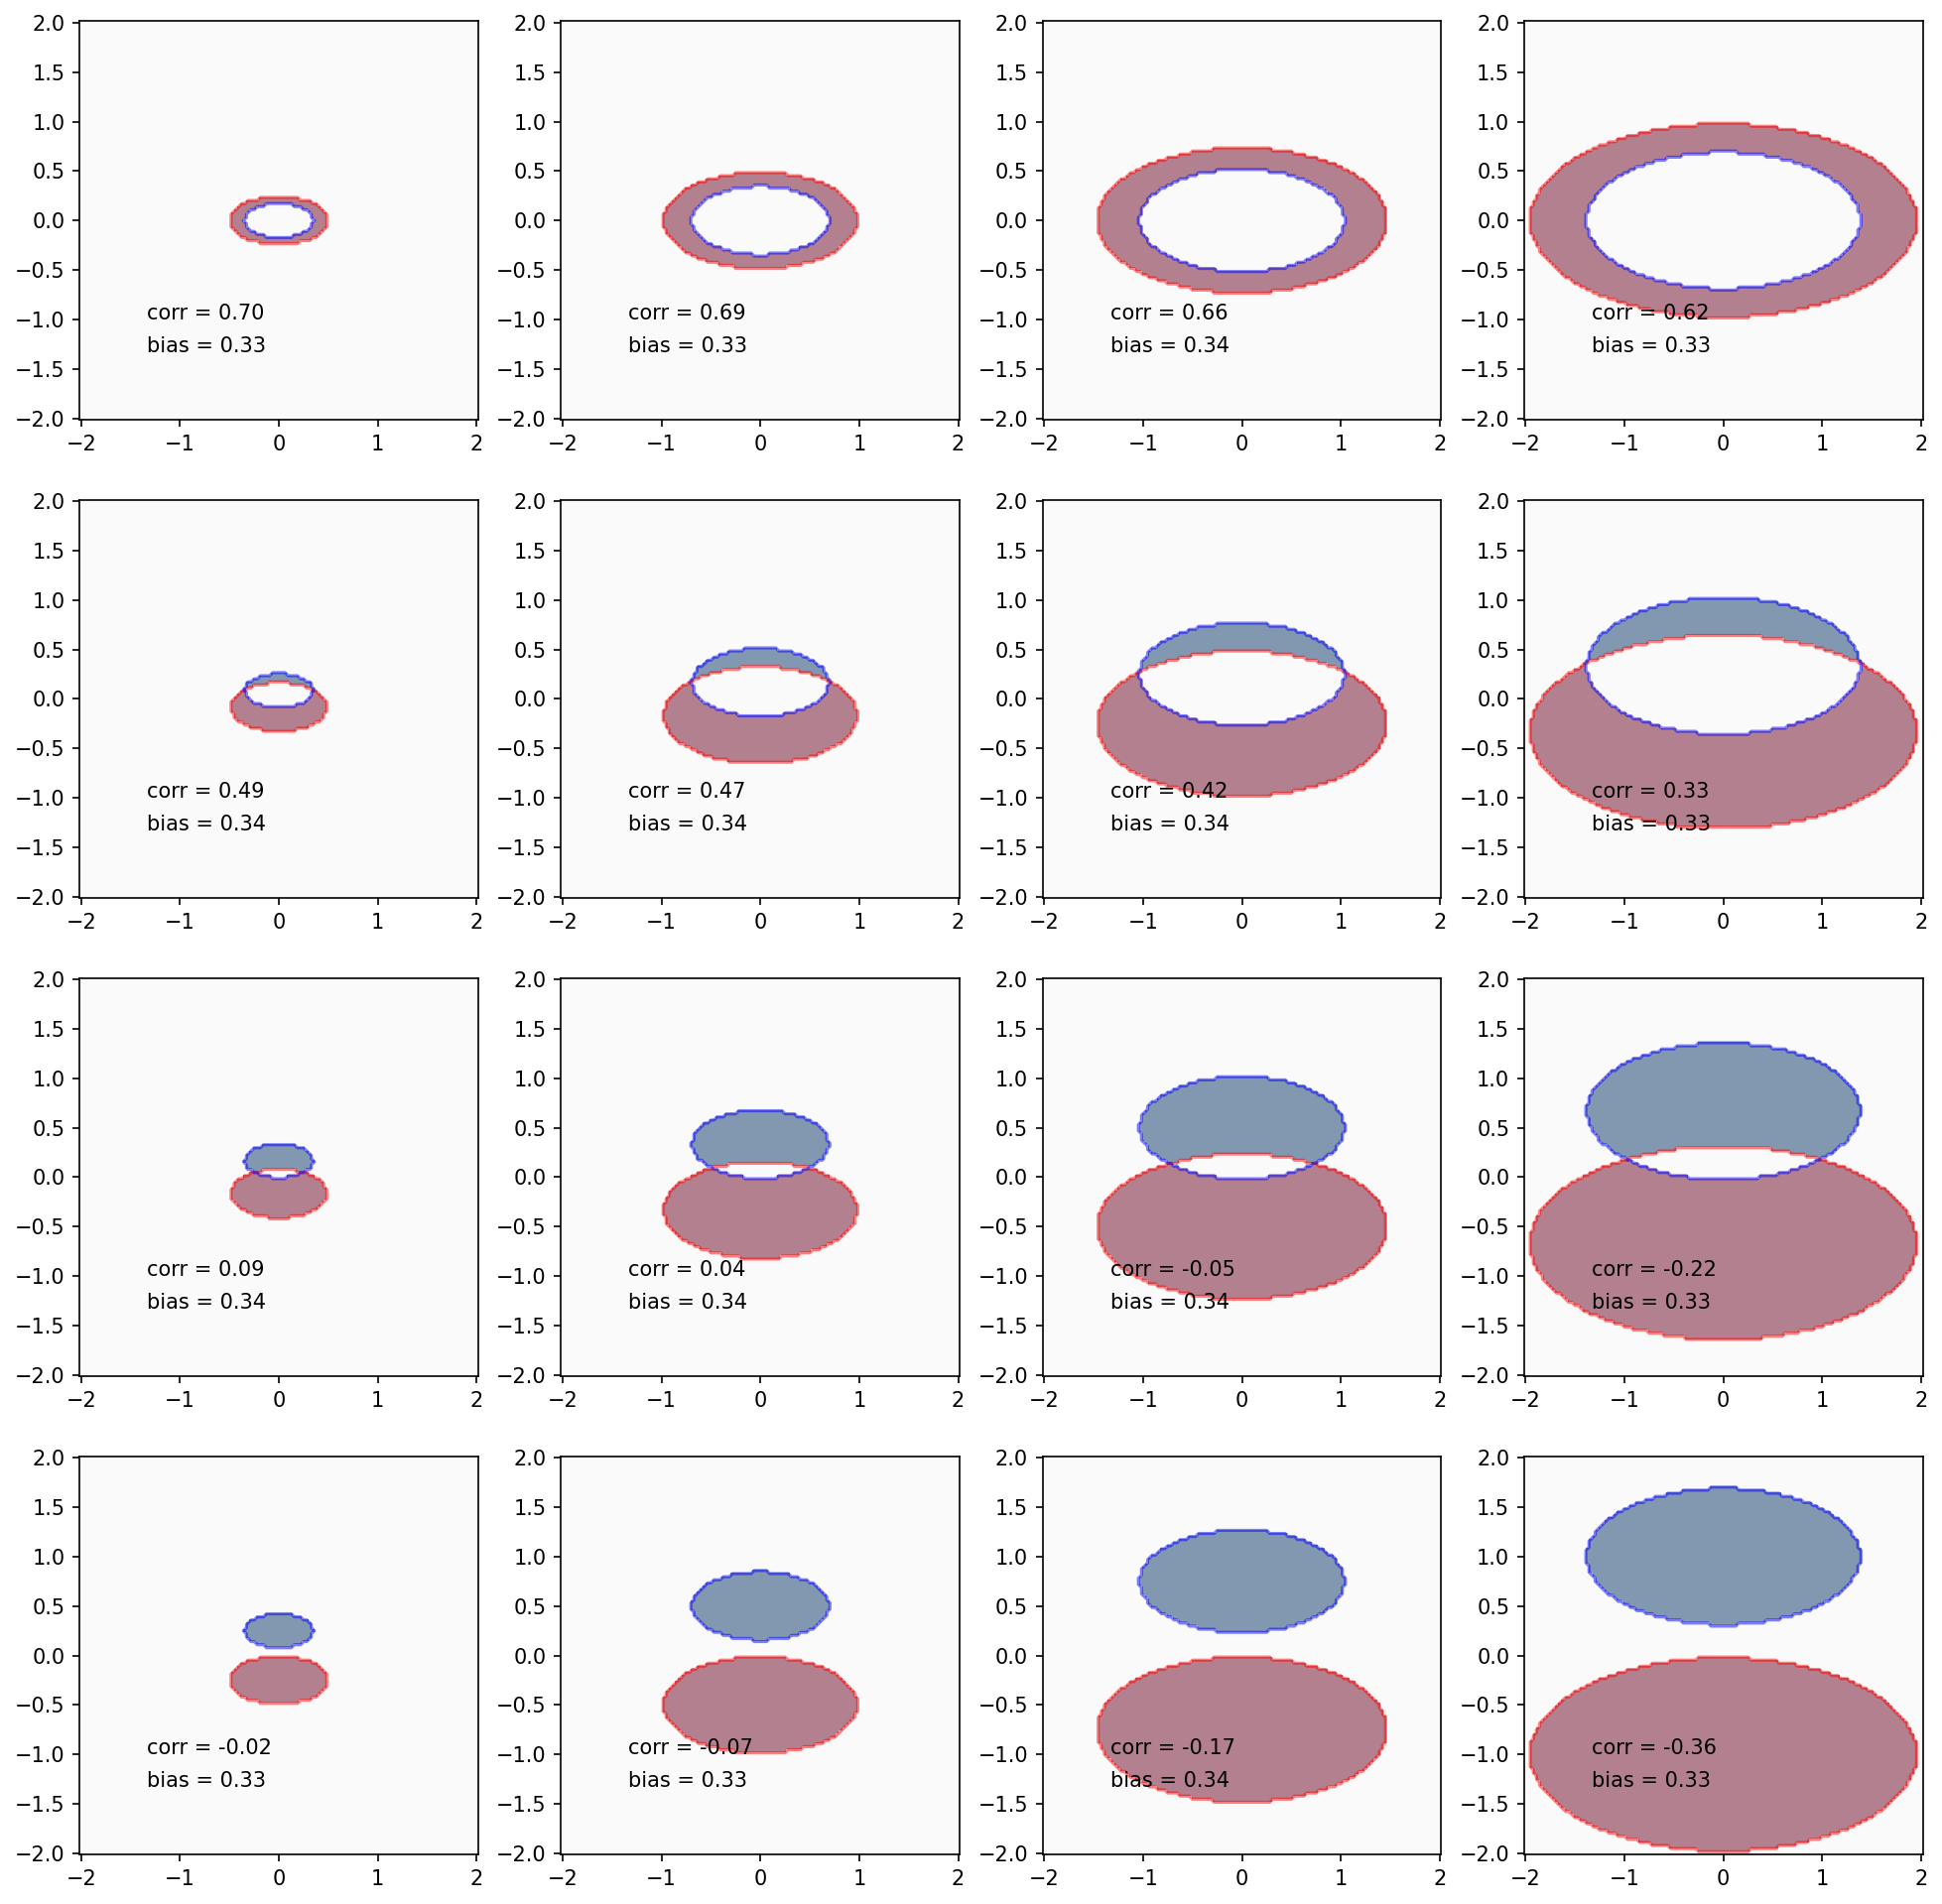

In [ ]:
fig,axs = plt.subplots(4,4,figsize=(16,16),dpi=150)

for i,d in enumerate(np.linspace(0,2,4)):
    for j,s in enumerate([0.25,0.5,0.75,1]):
        ON = (ellipse_fn(*get_axes(0.5,6*s**2))(x,y+d*s/2) > 0).astype(int)
        OF = (ellipse_fn(*get_axes(0.5,0.5*6*s**2))(x,y-d*s/2) > 0).astype(int)
        axs[i,j].imshow(ON-OF,origin='lower',extent=extent,cmap='RdBu_r',vmin=-1,vmax=1,alpha=0.5)
        axs[i,j].contour(ON,origin='lower',extent=extent,levels=[0.5],colors='r',alpha=0.5)
        axs[i,j].contour(OF,origin='lower',extent=extent,levels=[0.5],colors='b',alpha=0.5)
    
        corr = np.corrcoef(ON.flatten(),OF.flatten())[0,1]
        bias = np.abs((ON.sum() - OF.sum()) / (ON.sum() + OF.sum()))
        
        axs[i,j].text(-L/3,-L/4,'corr = {:.2f}'.format(corr))
        axs[i,j].text(-L/3,-L/3,'bias = {:.2f}'.format(bias))